# ***Multi-Layer Perceptrons for Classification and Function Approximation***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Set seed:

In [ ]:
seed = 42

### Data

Generate data:

In [ ]:
def generate_class_data(n=100, mA=[1.0, 0.3], sigmaA=0.2, mB=[0.0, -0.1], sigmaB=0.3, seed=None):
    print("Using seed: " + str(seed))
    if seed is not None:
        np.random.seed(seed)
    classA = np.concatenate((np.random.randn(2, n//2) * sigmaA + np.array(mA).reshape(2, 1), np.random.randn(2, n//2) * sigmaA - np.array(mA).reshape(2, 1)), axis=1)
    classB = np.random.randn(2, n) * sigmaB + np.array(mB).reshape(2, 1)
    return classA, classB

def generate_data(classA, classB, seed=None):
    n_A = classA.shape[-1]
    n_B = classB.shape[-1]
    X = np.hstack((classA, classB))
    T = np.hstack((np.ones(n_A), -np.ones(n_B)))  # labels: +1 for classA, -1 for classB

    # shuffle data
    if seed is not None:
        np.random.seed(seed)
    indices = np.random.permutation(n_A + n_B)
    return X[:, indices], T[indices]

Visualize raw data

In [ ]:
def visualize_dataset(classA, classB):
    plt.scatter(classA[0, :], classA[1, :], marker='o', label='Class A', alpha=0.6)
    plt.scatter(classB[0, :], classB[1, :], marker='s', label='Class B', alpha=0.6)
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    plt.title('Data distribution')
    plt.legend()
    plt.show()

Generate first data and visualize

Using seed: 100


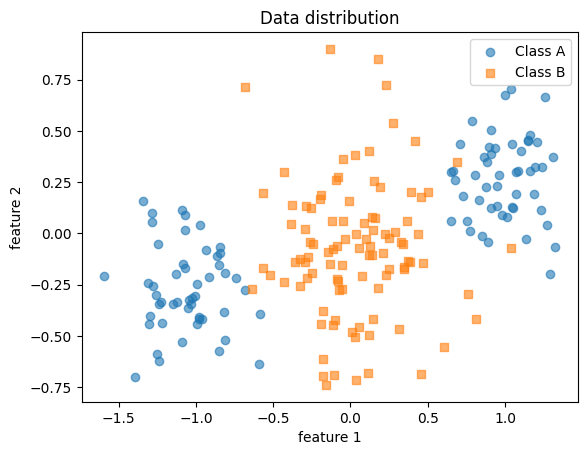

In [ ]:
# generate data that is not linearly separable
seed = 100
classA, classB = generate_class_data(seed=seed)
visualize_dataset(classA, classB)
X, T = generate_data(classA, classB)

### Two-layer MLP

In [ ]:
class TwoLayerPerceptron:
    def __init__(self, input_size, output_size, hidden_size, lr, alpha):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.lr = lr
        self.alpha = alpha

        # Initialize with gaussian random mean 0
        self.W = np.random.randn(self.hidden_size, self.input_size + 1) #* 0.01
        self.V = np.random.randn(self.output_size, self.hidden_size + 1) #* 0.01

        self.dW = np.zeros_like(self.W) # momentum for output layer
        self.dV = np.zeros_like(self.V) # momentum for hidden layer

        # Store forward pass
        self._hidden_output = None
        self._output = None

    def activation(self, X):
        return (2 / (1 + np.exp(-X))) - 1

    def activation_derivative(self, X):
        return ((1 + X) * (1 - X)) * 0.5

    def forward(self, X):
        hin = self.W @ np.vstack([X, np.ones((1, X.shape[-1]))])
        hidden_output = np.vstack([self.activation(hin), np.ones((1, X.shape[-1]))])
        output = self.activation(self.V @ hidden_output)

        # Store the forward pass output for future gradient updates
        self._hidden_output = hidden_output
        self._output = output

        return output

    def backprop(self, X, T):
        X_with_bias = np.vstack([X, np.ones((1, X.shape[-1]))])

        error_output = (self._output - T) * self.activation_derivative(self._output)
        error_hidden = (self.V.T @ error_output)[:-1, :] * self.activation_derivative(self._hidden_output[:-1, :])
        error_hidden = error_hidden[:self.hidden_size, :]

        # Weigh updates
        self.dW = self.alpha * self.dW - (1 - self.alpha) * (error_hidden @ X_with_bias.T)
        self.dV = self.alpha * self.dV - (1 - self.alpha) * (error_output @ self._hidden_output.T)

        self.W += self.lr * self.dW
        self.V += self.lr * self.dV

    def backprop_sequential(self, x_i, t_i):
        # Add bias term to the input
        x_with_bias = np.vstack([x_i, np.ones((1, x_i.shape[-1]))])  # Shape: (input_size + 1, 1)

        # Forward pass
        hidden_input = self.W @ x_with_bias  # Shape: (hidden_size, 1)
        hidden_output = np.vstack([self.activation(hidden_input), np.ones((1, 1))])  # Shape: (hidden_size + 1, 1)
        output_input = self.V @ hidden_output  # Shape: (output_size, 1)
        output = self.activation(output_input)  # Shape: (output_size, 1)

        # Compute error at the output layer
        error_output = (output - t_i) * self.activation_derivative(output)  # Shape: (output_size, 1)

        # Compute error at the hidden layer
        error_hidden = (self.V.T @ error_output)[:-1, :] * self.activation_derivative(hidden_output[:-1, :])  # Shape: (hidden_size, 1)

        # Update weights with momentum
        self.dW = self.alpha * self.dW - (1 - self.alpha) * (error_hidden @ x_with_bias.T)  # Shape: (hidden_size, input_size + 1)
        self.dV = self.alpha * self.dV - (1 - self.alpha) * (error_output @ hidden_output.T)  # Shape: (output_size, hidden_size + 1)

        # Apply weight updates
        self.W += self.lr * self.dW  # Shape: (hidden_size, input_size + 1)
        self.V += self.lr * self.dV  # Shape: (output_size, hidden_size + 1)

    def compute_loss(self, X, T):
        T_predict = self.forward(X)
        # Mean Squared Error
        MSE = np.sum((T - T_predict) ** 2)

        # number of misclassified instances
        predictions = np.where(T_predict >= 0, 1, -1)
        correct_count = np.sum(predictions == T)

        return MSE / X.shape[-1], correct_count / X.shape[-1]

In [ ]:
def plot_metrics(MSE, accuracy):
    # plot loss curves after training
    plt.figure()
    plt.plot(range(epochs), MSE, marker='o')
    plt.title(f"Learning curve with {hidden_size} node(s) in the hidden layer")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(range(epochs), accuracy, marker='o')
    plt.title(f"Accuracy curve with {hidden_size} node(s) in the hidden layer")
    plt.xlabel("Epochs")
    plt.ylabel("Number of misclassified instances")
    plt.grid()
    plt.show()
    print("Final MSE: " + str(MSE[-1]))
    print("Final Accuracy: " + str(accuracy[-1]))

def plot_metrics_train_val(MSE, accuracy, MSE_val, accuracy_val):
    # plot loss curves after training
    plt.figure()
    plt.plot(range(epochs), MSE, marker='o')
    plt.plot(range(epochs), MSE_val, marker='x')
    plt.title(f"Learning curve with {hidden_size} node(s) in the hidden layer")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(range(epochs), accuracy, marker='o')
    plt.plot(range(epochs), accuracy_val, marker='x')
    plt.title(f"Accuracy curve with {hidden_size} node(s) in the hidden layer")
    plt.xlabel("Epochs")
    plt.ylabel("Number of misclassified instances")
    plt.grid()
    plt.show()
    print("Final MSE: " + str(MSE[-1]))
    print("Final Accuracy: " + str(accuracy[-1]))
    print("Final evaluatuon MSE: " + str(MSE_val[-1]))
    print("Final evaluation Accuracy: " + str(accuracy_val[-1]))

def plot_average_metrics(all_MSE, all_accuracy):
    mean_MSE = np.mean(all_MSE, axis=0)
    std_MSE = np.std(all_MSE, axis=0)
    mean_accuracy = np.mean(all_accuracy, axis=0)
    std_accuracy = np.std(all_accuracy, axis=0)

    epochs = range(len(mean_MSE))

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, mean_MSE, label='Mean MSE', color='blue')
    plt.fill_between(epochs, mean_MSE - std_MSE, mean_MSE + std_MSE, color='blue', alpha=0.2)
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title("Mean Squared Error Over Epochs (Mean ± Std Dev)")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, mean_accuracy, label='Mean Accuracy', color='orange')
    plt.fill_between(epochs, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, color='orange', alpha=0.2)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs (Mean ± Std Dev)")
    plt.legend()
    plt.grid()
    plt.show()
    print("Final MSE: " + str(mean_MSE[-1]))
    print("Final acc: " + str(mean_accuracy[-1]))


def plot_average_metrics_split(all_MSE_train, all_acc_train, all_MSE_val, all_acc_val):
    # compute mean and std deviation across runs
    mean_MSE_train = np.mean(all_MSE_train, axis=0)
    std_MSE_train = np.std(all_MSE_train, axis=0)

    mean_MSE_val = np.mean(all_MSE_val, axis=0)
    std_MSE_val = np.std(all_MSE_val, axis=0)

    mean_acc_train = np.mean(all_acc_train, axis=0)
    std_acc_train = np.std(all_acc_train, axis=0)

    mean_acc_val = np.mean(all_acc_val, axis=0)
    std_acc_val = np.std(all_acc_val, axis=0)

    epochs = range(len(mean_MSE_train))

    # plot Mean Squared Error (Loss)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, mean_MSE_train, label='Training Loss (MSE)', color='blue')
    plt.fill_between(epochs, mean_MSE_train - std_MSE_train, mean_MSE_train + std_MSE_train, color='blue', alpha=0.2)

    plt.plot(epochs, mean_MSE_val, label='Validation Loss (MSE)', color='red')
    plt.fill_between(epochs, mean_MSE_val - std_MSE_val, mean_MSE_val + std_MSE_val, color='red', alpha=0.2)

    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title("Training vs Validation Loss (Mean ± Std Dev)")
    plt.legend()
    plt.grid()
    plt.show()

    # plot Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, mean_acc_train, label='Training Accuracy', color='green')
    plt.fill_between(epochs, mean_acc_train - std_acc_train, mean_acc_train + std_acc_train, color='green', alpha=0.2)

    plt.plot(epochs, mean_acc_val, label='Validation Accuracy', color='orange')
    plt.fill_between(epochs, mean_acc_val - std_acc_val, mean_acc_val + std_acc_val, color='orange', alpha=0.2)

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy (Mean ± Std Dev)")
    plt.legend()
    plt.grid()
    plt.show()

def plot_average_metrics_split_and_all(all_MSE_train, all_acc_train, all_MSE_val, all_acc_val, error_ceiling=None, plot_val=True):
    # compute mean and std deviation across runs
    if plot_val:
        all_MSE = (all_MSE_train + all_MSE_val) / 2
        all_acc = (all_acc_train + all_acc_val) / 2
    else:
        all_MSE = all_MSE_train
        all_acc = all_acc_train
    mean_MSE_all = np.mean(all_MSE, axis=0)
    std_MSE_all = np.std(all_MSE, axis=0)
    mean_acc_all = np.mean(all_acc, axis=0)
    std_acc_all = np.std(all_acc, axis=0)

    mean_MSE_train = np.mean(all_MSE_train, axis=0)
    std_MSE_train = np.std(all_MSE_train, axis=0)

    mean_MSE_val = np.mean(all_MSE_val, axis=0)
    std_MSE_val = np.std(all_MSE_val, axis=0)

    mean_acc_train = np.mean(all_acc_train, axis=0)
    std_acc_train = np.std(all_acc_train, axis=0)

    mean_acc_val = np.mean(all_acc_val, axis=0)
    std_acc_val = np.std(all_acc_val, axis=0)

    epochs = range(len(mean_MSE_train))

    # plot Mean Squared Error (Loss)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, mean_MSE_all, label='All Loss (MSE)', color='green')
    plt.fill_between(epochs, mean_MSE_all - std_MSE_all, mean_MSE_all + std_MSE_all, color='green', alpha=0.2)

    if error_ceiling != None:
        plt.ylim(0, error_ceiling)

    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title("Training vs Validation Loss (Mean ± Std Dev)")
    plt.legend()
    plt.grid()
    plt.show()
    print("Final MSE: " + str(mean_MSE_all[-1]))

def plot_batch_vs_seq(all_acc_val_batch, all_acc_val_seq):
    # batch
    mean_acc_val_batch = np.mean(all_acc_val_batch, axis=0)
    std_acc_val_batch = np.std(all_acc_val_batch, axis=0)

    # sequential
    mean_acc_val_seq = np.mean(all_acc_val_seq, axis=0)
    std_acc_val_seq = np.std(all_acc_val_seq, axis=0)

    epochs = range(len(mean_acc_val_batch))

    # plot Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, mean_acc_val_batch, label='Batch learning', color='green')
    plt.fill_between(epochs, mean_acc_val_batch - std_acc_val_batch, mean_acc_val_batch + std_acc_val_batch, color='green', alpha=0.2)

    plt.plot(epochs, mean_acc_val_seq, label='Sequential learning', color='orange')
    plt.fill_between(epochs, mean_acc_val_seq - std_acc_val_seq, mean_acc_val_seq + std_acc_val_seq, color='orange', alpha=0.2)

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Batch vs Sequential learning Accuracy (Mean ± Std Dev)")
    plt.legend()
    plt.grid()
    plt.show()

Training loops

In [ ]:
def training(model, X, T, epochs):
    MSE = []
    accuracy = []
    for epoch in range(epochs):
        predictions = model.forward(X)
        model.backprop(X, T)

        # compute and store the loss for this epoch
        epoch_MSE, epoch_miss = model.compute_loss(X, T)
        MSE.append(epoch_MSE)
        accuracy.append(epoch_miss)
    return MSE, accuracy

def training_validation(model, X_train, T_train, X_val, T_val, epochs, save_val=True, lr_adapt=False, tau=50):
    MSE_train = []
    MSE_val = []
    accuracy_train = []
    accuracy_val = []
    max_lr = model.lr
    for epoch in range(epochs):
        predictions = model.forward(X_train)
        model.backprop(X_train, T_train)

        #Update learning rate
        if lr_adapt:
            model.lr = max_lr / ((epochs / tau) + 1)

        # compute and store the loss for this epoch
        epoch_MSE_train, epoch_acc_train = model.compute_loss(X_train, T_train)
        if save_val:
            epoch_MSE_val, epoch_acc_val = model.compute_loss(X_val, T_val)
            MSE_val.append(epoch_MSE_val)
            accuracy_val.append(epoch_acc_val)
        MSE_train.append(epoch_MSE_train)
        accuracy_train.append(epoch_acc_train)

    return MSE_train, accuracy_train, MSE_val, accuracy_val

def training_validation_sequential(model, X_train, T_train, X_val, T_val, epochs):
    MSE_train = []
    MSE_val = []
    accuracy_train = []
    accuracy_val = []

    for epoch in range(epochs):
        epoch_MSE_train = 0
        epoch_acc_train = 0
        epoch_MSE_val = 0
        epoch_acc_val = 0

        for i in range(X_train.shape[1]):
            x_i = X_train[:, i].reshape(-1, 1)
            t_i = T_train[i].reshape(1, 1) if T_train.ndim == 1 else T_train[:, i].reshape(-1, 1)

            model.forward(x_i)
            model.backprop_sequential(x_i, t_i)

            epoch_MSE_train_sample, epoch_acc_train_sample = model.compute_loss(x_i, t_i)
            epoch_MSE_train += epoch_MSE_train_sample
            epoch_acc_train += epoch_acc_train_sample

        # Average loss and accuracy for training set
        epoch_MSE_train /= X_train.shape[1]
        epoch_acc_train /= X_train.shape[1]

        epoch_MSE_val, epoch_acc_val = model.compute_loss(X_val, T_val)

        MSE_train.append(epoch_MSE_train)
        accuracy_train.append(epoch_acc_train)
        MSE_val.append(epoch_MSE_val)
        accuracy_val.append(epoch_acc_val)

    return np.array(MSE_train), np.array(accuracy_train), np.array(MSE_val), np.array(accuracy_val)

def training_multiple_runs(model_class, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs=5):
    """to average over multiple weight initialization"""
    all_MSE = []
    all_accuracy = []

    for seed in range(n_runs):
        np.random.seed(seed)
        model = model_class(input_size, output_size, hidden_size, lr, alpha)
        MSE, accuracy = training(model, X, T, epochs)
        all_MSE.append(MSE)
        all_accuracy.append(accuracy)

    return np.array(all_MSE), np.array(all_accuracy)

def training_multiple_runs_return_model(model_class, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs=5):
    """to average over multiple weight initialization"""
    all_MSE = []
    all_accuracy = []

    for seed in range(n_runs):
        np.random.seed(seed)
        model = model_class(input_size, output_size, hidden_size, lr, alpha)
        MSE, accuracy = training(model, X, T, epochs)
        all_MSE.append(MSE)
        all_accuracy.append(accuracy)

    return np.array(all_MSE), np.array(all_accuracy), model

def subsample_data(X, T, scenario):
    """subsamples training data based on the given scenario."""
    # extract Class A (+1) and Class B (-1) from X
    X_A, T_A = X[:, T == 1], T[T == 1]  # Class A
    X_B, T_B = X[:, T == -1], T[T == -1]  # Class B

    if scenario == "25% each class":
        # randomly select 25% from each class
        idx_A = np.random.choice(X_A.shape[1], size=int(0.25 * X_A.shape[1]), replace=False)
        idx_B = np.random.choice(X_B.shape[1], size=int(0.25 * X_B.shape[1]), replace=False)

    elif scenario == "80% each class":
        # randomly select 80% from each class
        idx_A = np.random.choice(X_A.shape[1], size=int(0.80 * X_A.shape[1]), replace=False)
        idx_B = np.random.choice(X_B.shape[1], size=int(0.80 * X_B.shape[1]), replace=False)

    elif scenario == "50% class A":
        # randomly select 50% from class A
        idx_A = np.random.choice(X_A.shape[1], size=int(0.5 * X_A.shape[1]), replace=False)
        idx_B = np.arange(X_B.shape[1])  # Use all of class B

    elif scenario == "20%-80% class A":
        # split class A based on feature condition X_A[0]
        idx_A_neg = np.where(X_A[0, :] < 0)[0]  # Class A samples where X_A[0] < 0
        idx_A_pos = np.where(X_A[0, :] > 0)[0]  # Class A samples where X_A[0] > 0

        # select 20% from the negative subset and 80% from the positive subset
        idx_A_neg_sampled = np.random.choice(idx_A_neg, size=int(0.2 * len(idx_A_neg)), replace=False)
        idx_A_pos_sampled = np.random.choice(idx_A_pos, size=int(0.8 * len(idx_A_pos)), replace=False)
        idx_A = np.concatenate([idx_A_neg_sampled, idx_A_pos_sampled])
        idx_B = np.arange(X_B.shape[1])  # Use all of class B

    else:
        raise ValueError("Invalid subsampling scenario selected.")

    # Subsample data
    X_train = np.concatenate((X_A[:, idx_A], X_B[:, idx_B]), axis=1)
    T_train = np.concatenate((T_A[idx_A], T_B[idx_B]))

    # remaining data for validation
    mask = ~np.isin(np.arange(X.shape[1]), np.arange(X_train.shape[1]))
    X_val, T_val = X[:, mask], T[mask]

    return X_train, T_train, X_val, T_val

def subsample_data_gauss_data(X, T, scenario):
    """subsamples training data based on the given scenario."""

    if scenario == "20%":
        idx = np.random.choice(X.shape[1], size=int(0.20 * X.shape[1]), replace=False)

    elif scenario == "40%":
        idx = np.random.choice(X.shape[1], size=int(0.40 * X.shape[1]), replace=False)

    elif scenario == "60%":
        idx = np.random.choice(X.shape[1], size=int(0.60 * X.shape[1]), replace=False)

    elif scenario == "80%":
        idx = np.random.choice(X.shape[1], size=int(0.80 * X.shape[1]), replace=False)

    elif scenario == "100%":
        return np.array(X), np.array(T), None, None

    else:
        raise ValueError("Invalid subsampling scenario selected.")

    # Subsample data
    X_train = X[:, idx]
    T_train = T[idx]

    # remaining data for validation
    mask = ~np.isin(np.arange(X.shape[1]), np.arange(X_train.shape[1]))
    X_val, T_val = X[:, mask], T[mask]

    return X_train, T_train, X_val, T_val


def training_multiple_runs_split(
    model_class, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs=5, scenario="25% each class"):
    """to average over multiple weight initialization and multiple splits"""

    all_MSE_train = []
    all_acc_train = []
    all_MSE_val = []
    all_acc_val = []

    for seed in range(n_runs):
        np.random.seed(seed)  # different seed for each run

        # generate new train/validation split using chosen scenario
        X_train, T_train, X_val, T_val = subsample_data(X, T, scenario)

        # initialize a new model with different weight initialization
        model = model_class(input_size, output_size, hidden_size, lr, alpha)

        # train the model
        MSE_train, acc_train, MSE_val, acc_val = training_validation(
            model, X_train, T_train, X_val, T_val, epochs)

        # store results
        all_MSE_train.append(MSE_train)
        all_acc_train.append(acc_train)
        all_MSE_val.append(MSE_val)
        all_acc_val.append(acc_val)

    # convert lists to numpy arrays for easier analysis
    return (np.array(all_MSE_train), np.array(all_acc_train),
            np.array(all_MSE_val), np.array(all_acc_val))

def training_multiple_runs_split_sequential(
    model_class, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs=5, scenario="25% each class"):
    """to average over multiple weight initialization and multiple splits"""

    all_MSE_train = []
    all_acc_train = []
    all_MSE_val = []
    all_acc_val = []

    for seed in range(n_runs):
        np.random.seed(seed)  # different seed for each run

        # generate new train/validation split using chosen scenario
        X_train, T_train, X_val, T_val = subsample_data(X, T, scenario)

        # initialize a new model with different weight initialization
        model = model_class(input_size, output_size, hidden_size, lr, alpha)

        # train the model
        MSE_train, acc_train, MSE_val, acc_val = training_validation_sequential(
            model, X_train, T_train, X_val, T_val, epochs)

        # store results
        all_MSE_train.append(MSE_train)
        all_acc_train.append(acc_train)
        all_MSE_val.append(MSE_val)
        all_acc_val.append(acc_val)

    # convert lists to numpy arrays for easier analysis
    return (np.array(all_MSE_train), np.array(all_acc_train),
            np.array(all_MSE_val), np.array(all_acc_val))

## 1) Classification

### Effect of the hidden size

Using seed: 42


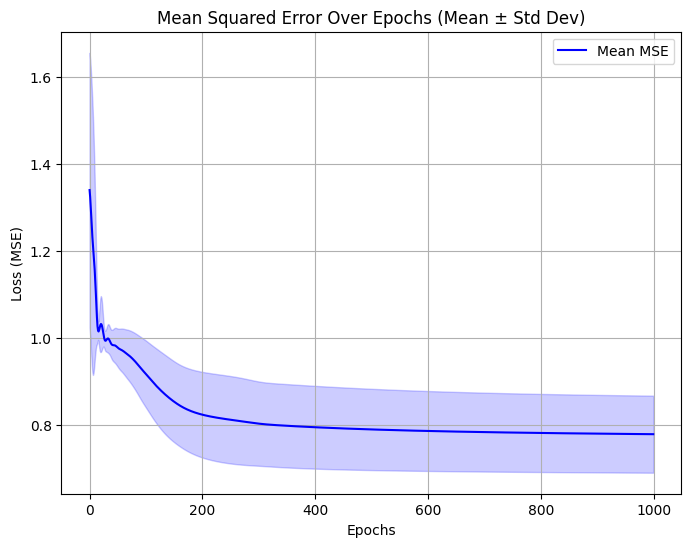

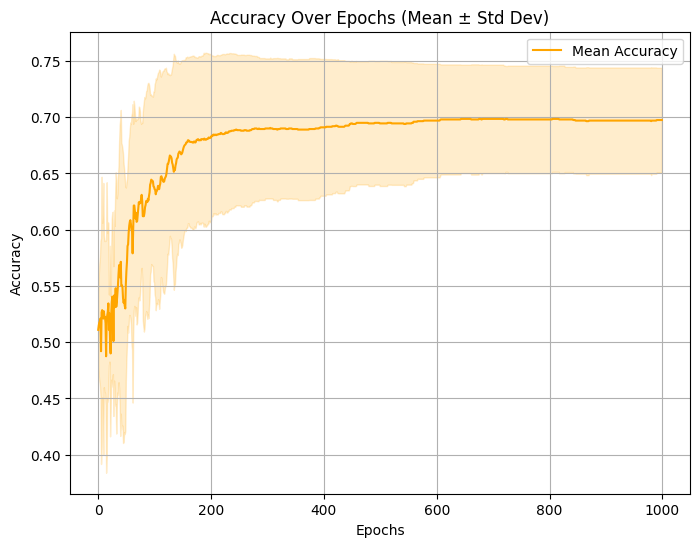

Final MSE: 0.7787631802875511
Final acc: 0.6975


In [ ]:
n_runs = 10
epochs = 1000
hidden_size = 1
lr = 0.01
alpha = 0.9
input_size = X.shape[0]
output_size = 1
seed = 42

#Hard
#classA, classB = generate_class_data(mA=[0.5, 0.1], sigmaA=0.2, mB=[0.0, -0.1], sigmaB=0.3, seed=seed)

#Easy
classA, classB = generate_class_data(seed=seed)

#Super easy
#classA, classB = generate_class_data(mA=[1.1, 0.4], sigmaA=0.2, mB=[-0.1, -0.2], sigmaB=0.3, seed=seed)

X, T = generate_data(classA, classB)

# run multiple training sessions
all_MSE, all_accuracy = training_multiple_runs(TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs)

# plot results
plot_average_metrics(all_MSE, all_accuracy)

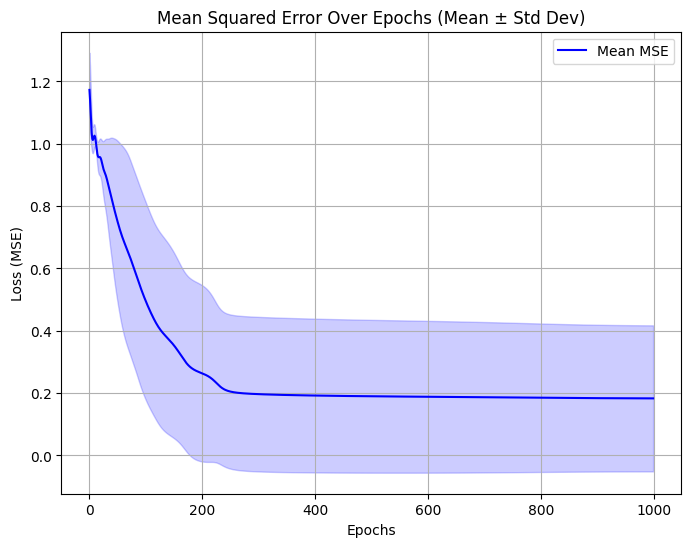

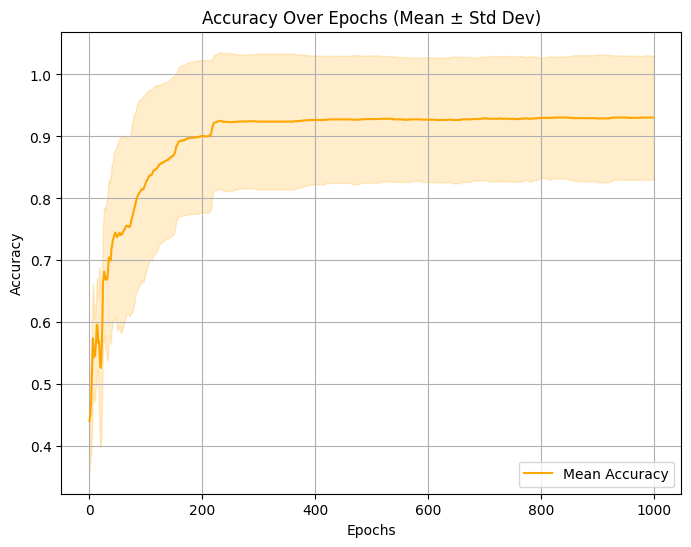

Final MSE: 0.18309523826112523
Final acc: 0.9305000000000001


In [ ]:
hidden_size = 2

# run multiple training sessions
all_MSE, all_accuracy = training_multiple_runs(TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs)

# plot results
plot_average_metrics(all_MSE, all_accuracy)

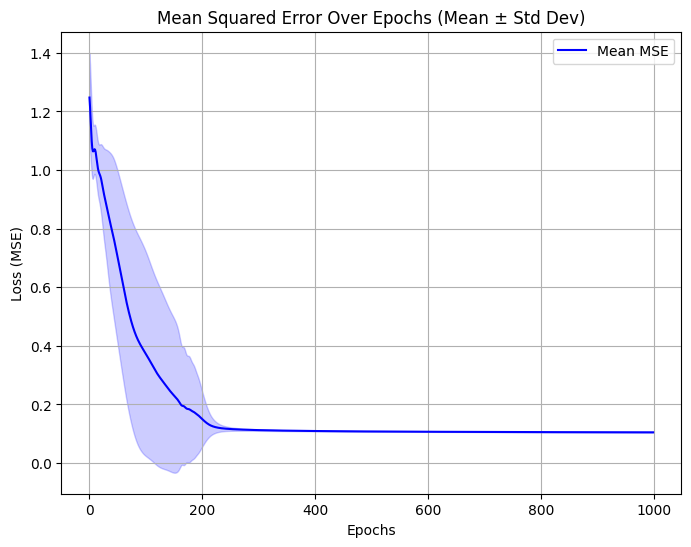

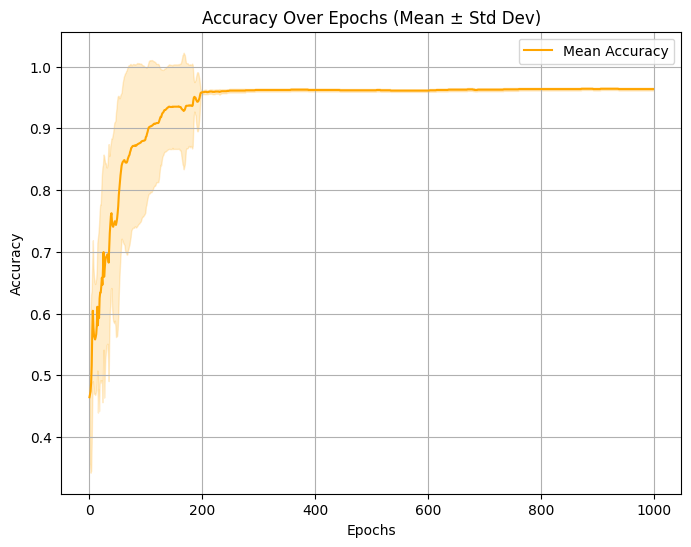

Final MSE: 0.1049433345009827
Final acc: 0.9634999999999998


In [ ]:
hidden_size = 3

# run multiple training sessions
all_MSE, all_accuracy = training_multiple_runs(TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs)

# plot results
plot_average_metrics(all_MSE, all_accuracy)

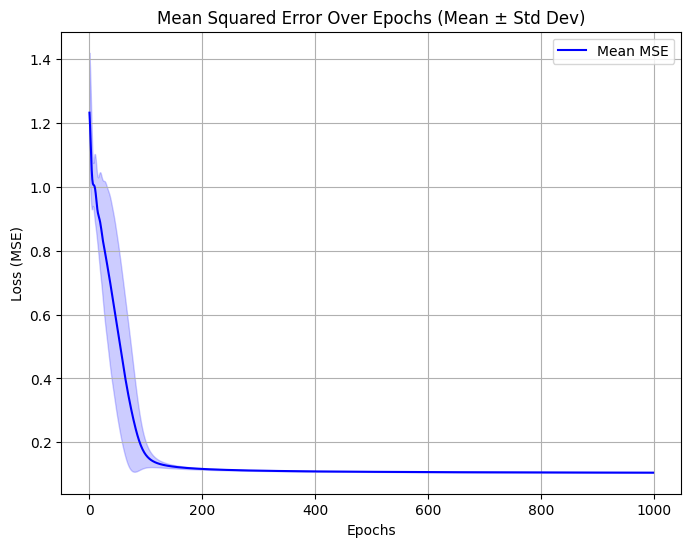

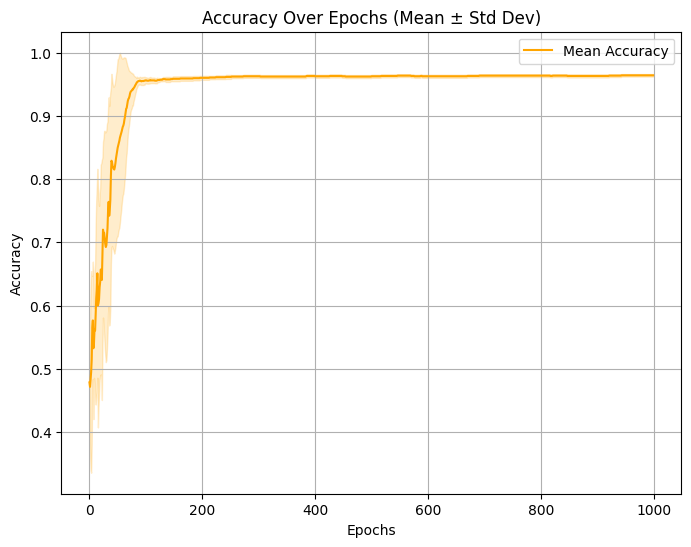

Final MSE: 0.10487119016967225
Final acc: 0.9639999999999999


In [ ]:
hidden_size = 4

# run multiple training sessions
all_MSE, all_accuracy = training_multiple_runs(TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs)

# plot results
plot_average_metrics(all_MSE, all_accuracy)

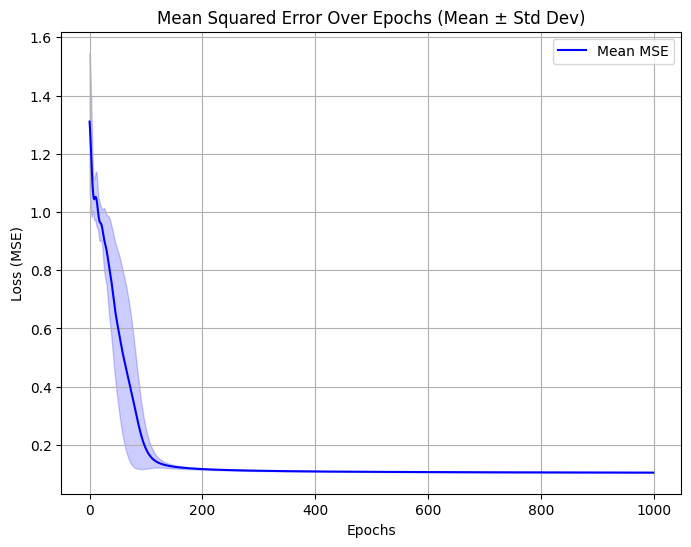

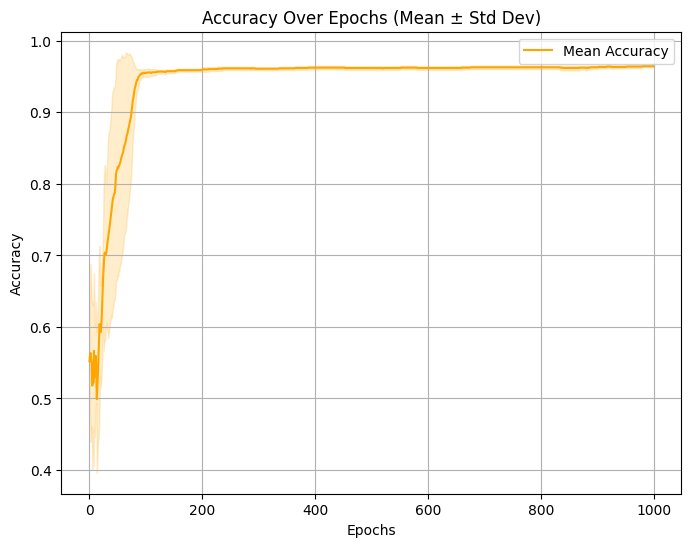

Final MSE: 0.10506600923120273
Final acc: 0.9644999999999999


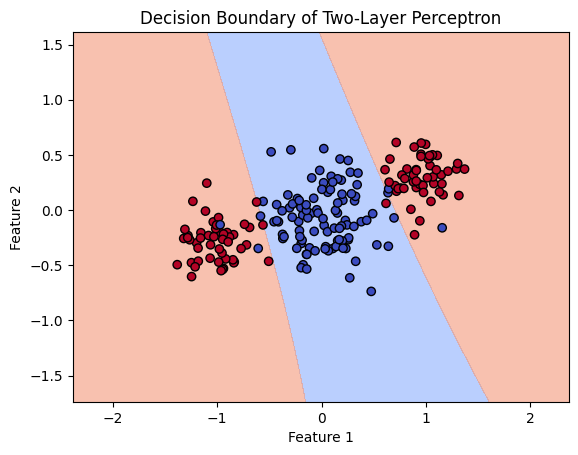

In [ ]:
hidden_size = 5

# run multiple training sessions
all_MSE, all_accuracy, model = training_multiple_runs_return_model(TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs)

# plot results
plot_average_metrics(all_MSE, all_accuracy)
plot_decision_boundary(model, X, T)

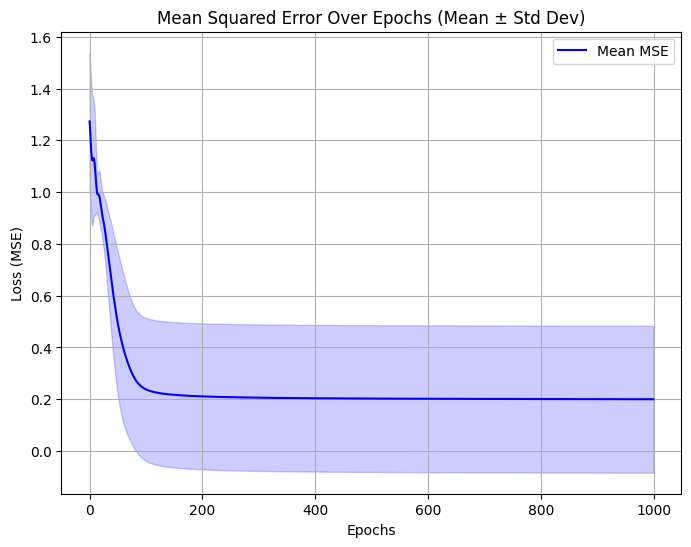

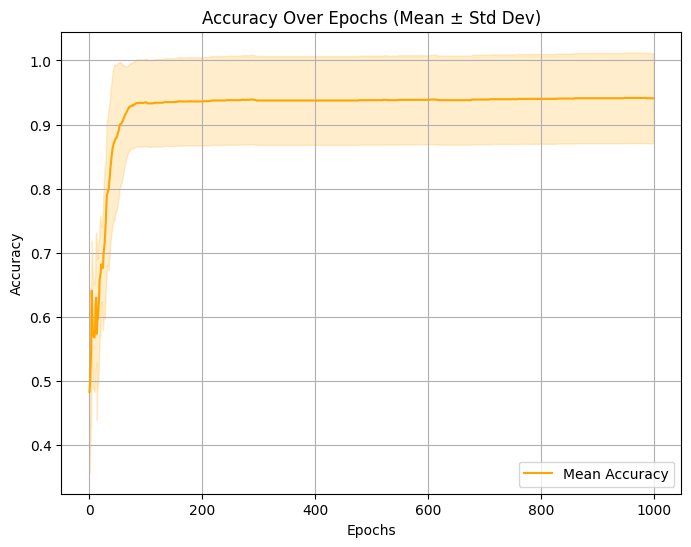

Final MSE: 0.1996886232668397
Final acc: 0.9410000000000001


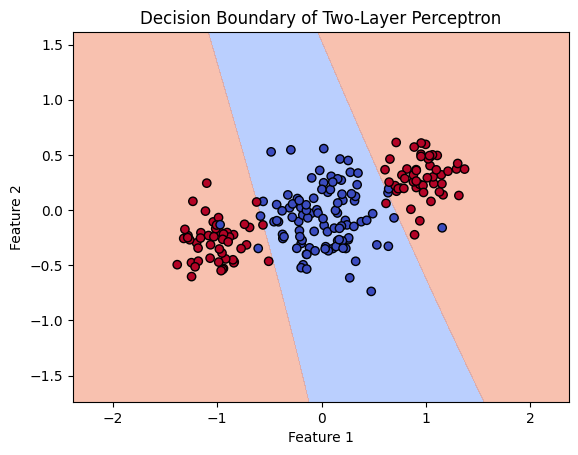

In [ ]:
hidden_size = 6

# run multiple training sessions
all_MSE, all_accuracy, model = training_multiple_runs_return_model(TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs)

# plot results
plot_average_metrics(all_MSE, all_accuracy)
plot_decision_boundary(model, X, T)

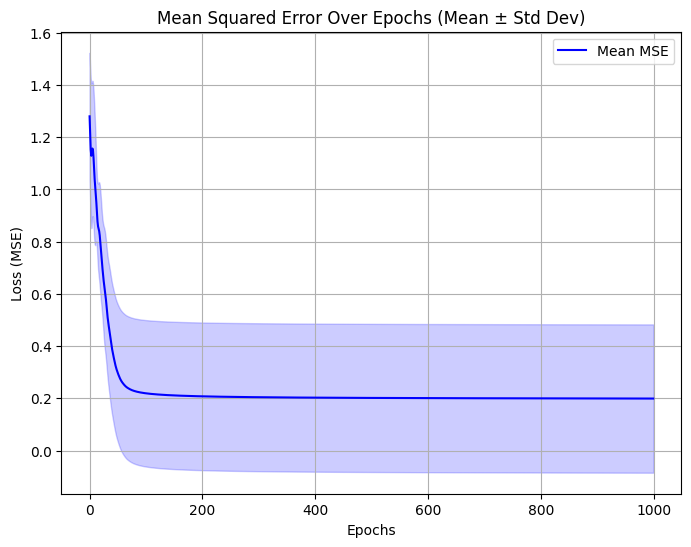

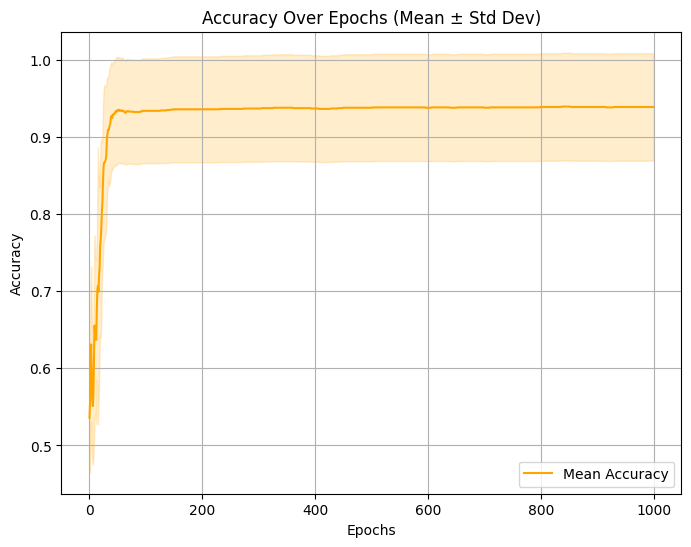

Final MSE: 0.1993000654680069
Final acc: 0.9390000000000001


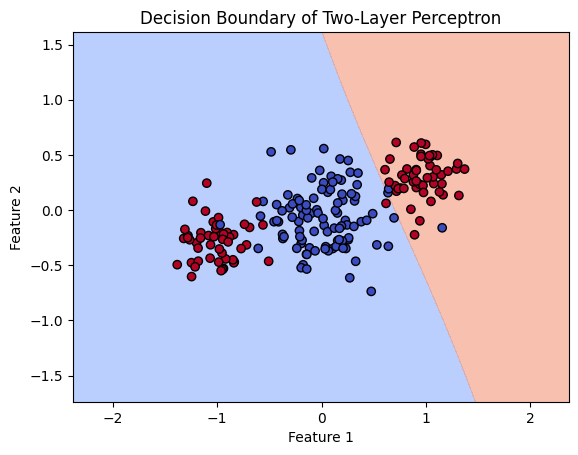

In [ ]:
hidden_size = 10

# run multiple training sessions
all_MSE, all_accuracy, model = training_multiple_runs_return_model(TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs)

# plot results
plot_average_metrics(all_MSE, all_accuracy)
plot_decision_boundary(model, X, T)

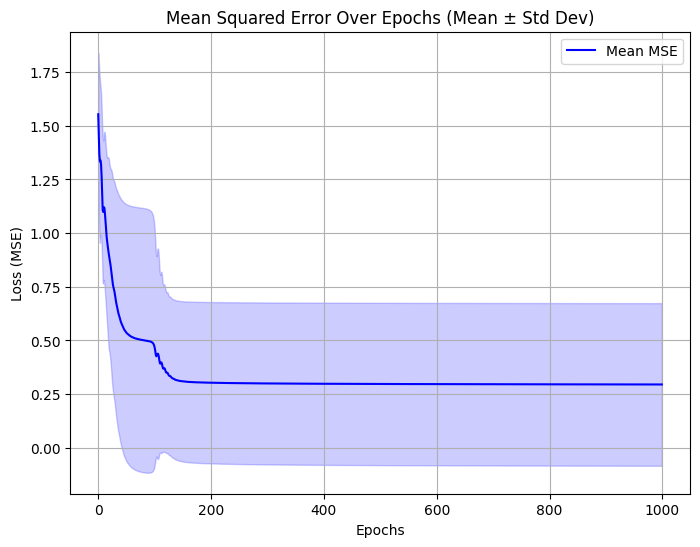

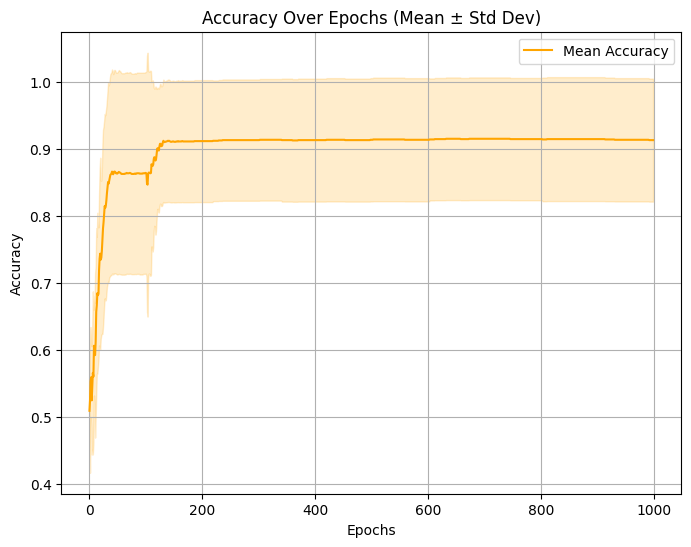

Final MSE: 0.29471049775392666
Final acc: 0.9135


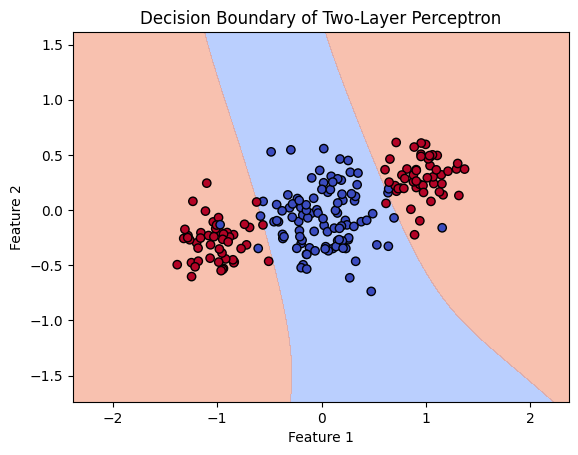

In [ ]:
hidden_size = 25

# run multiple training sessions
all_MSE, all_accuracy, model = training_multiple_runs_return_model(TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs)

# plot results
plot_average_metrics(all_MSE, all_accuracy)
plot_decision_boundary(model, X, T)

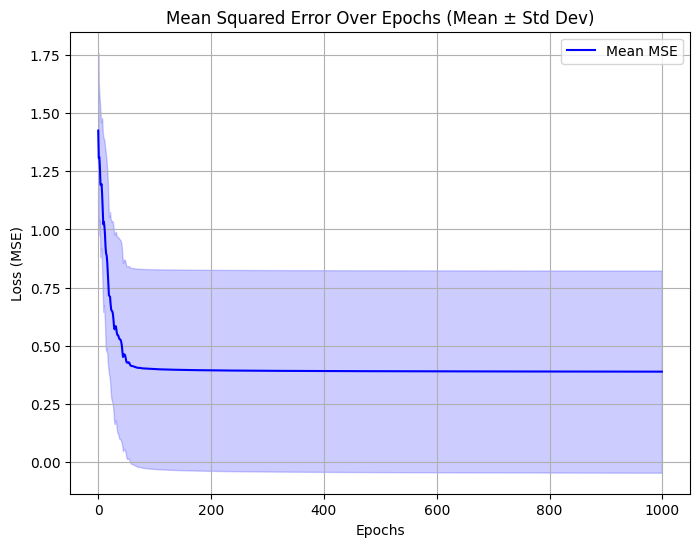

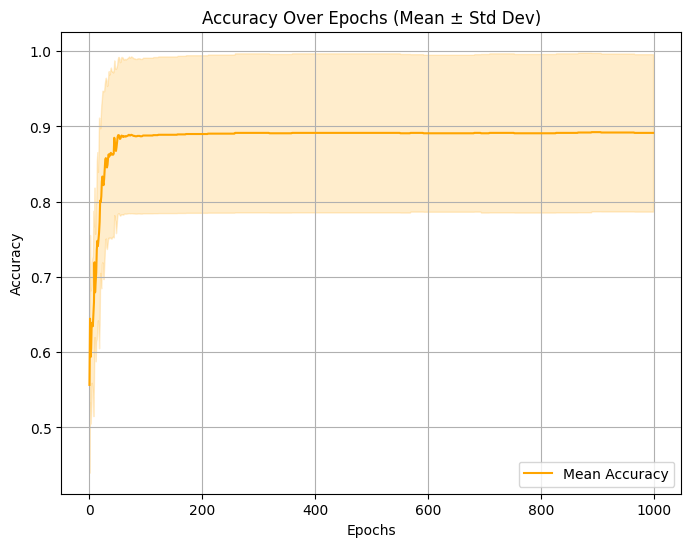

Final MSE: 0.38939282893753
Final acc: 0.8915


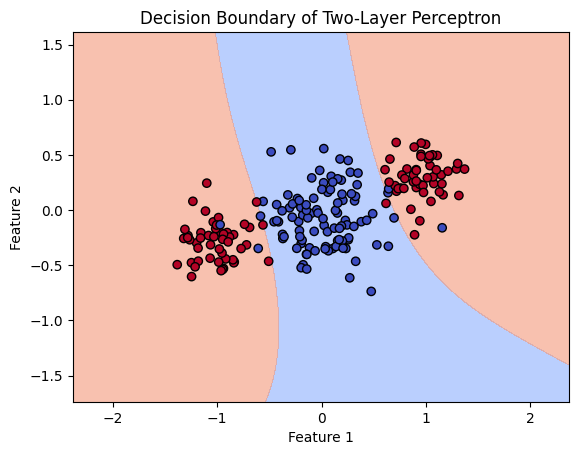

In [ ]:
hidden_size = 50

# run multiple training sessions
all_MSE, all_accuracy, model = training_multiple_runs_return_model(TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs)

# plot results
plot_average_metrics(all_MSE, all_accuracy)
plot_decision_boundary(model, X, T)

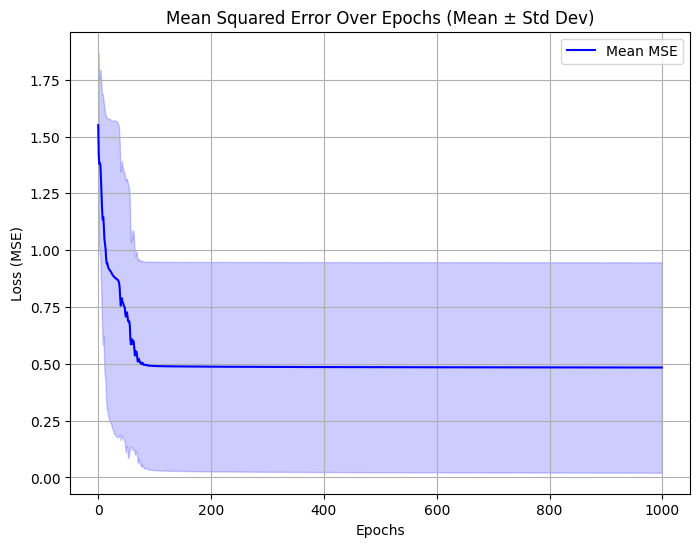

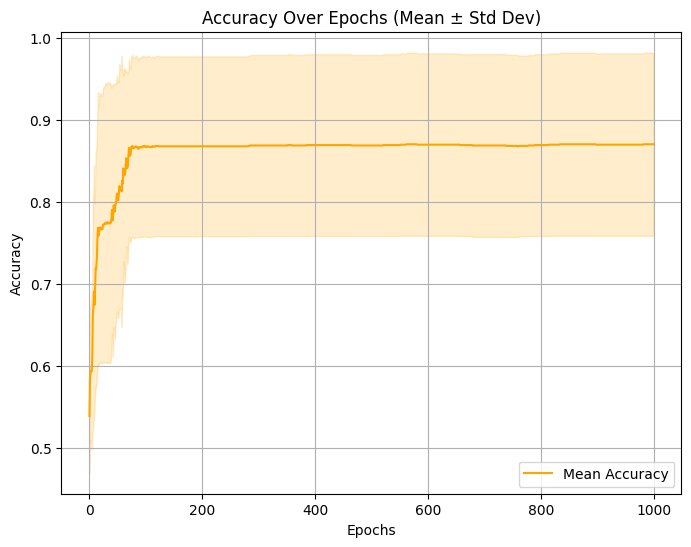

Final MSE: 0.48357450581637396
Final acc: 0.8705


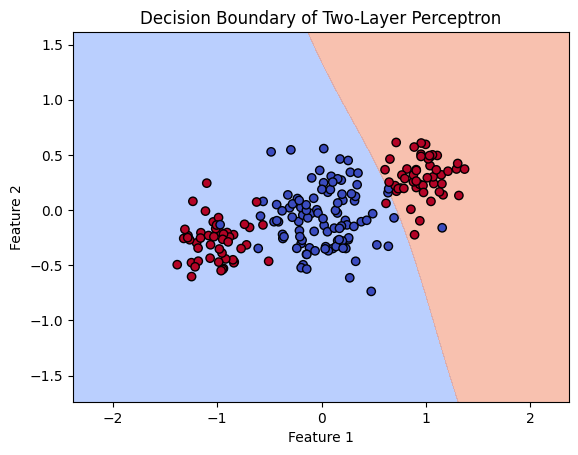

In [ ]:
hidden_size = 100

# run multiple training sessions
all_MSE, all_accuracy, model = training_multiple_runs_return_model(TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs)

# plot results
plot_average_metrics(all_MSE, all_accuracy)
plot_decision_boundary(model, X, T)

### Effect of class imbalance with different subsampling scenarios


Running scenario: 25% each class


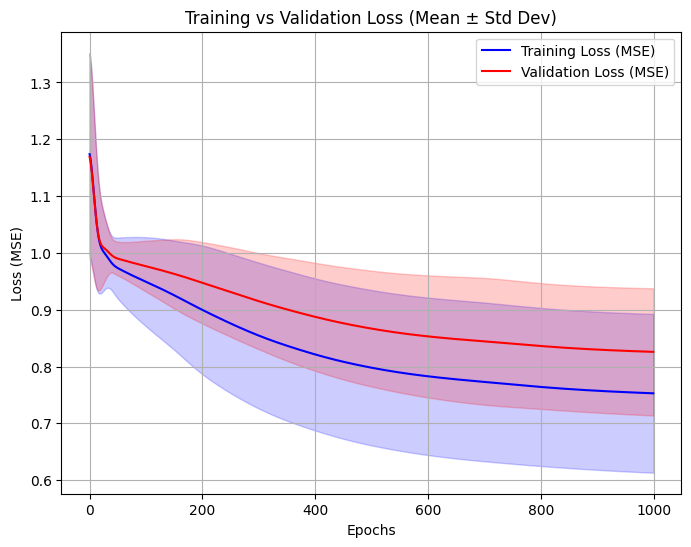

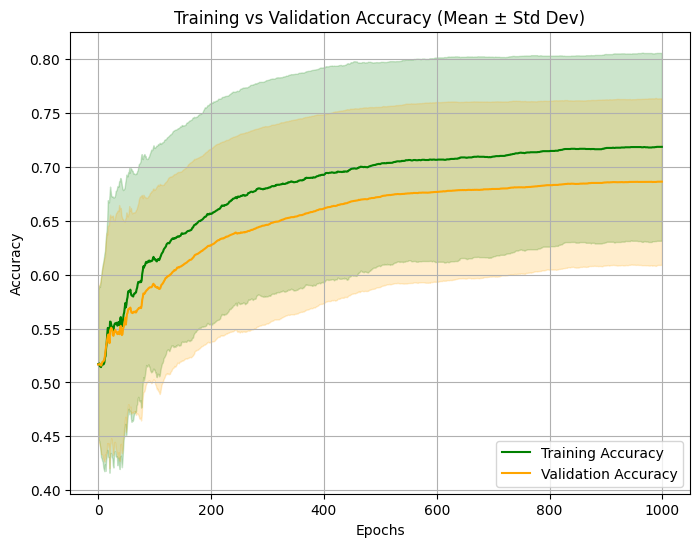


Running scenario: 50% class A


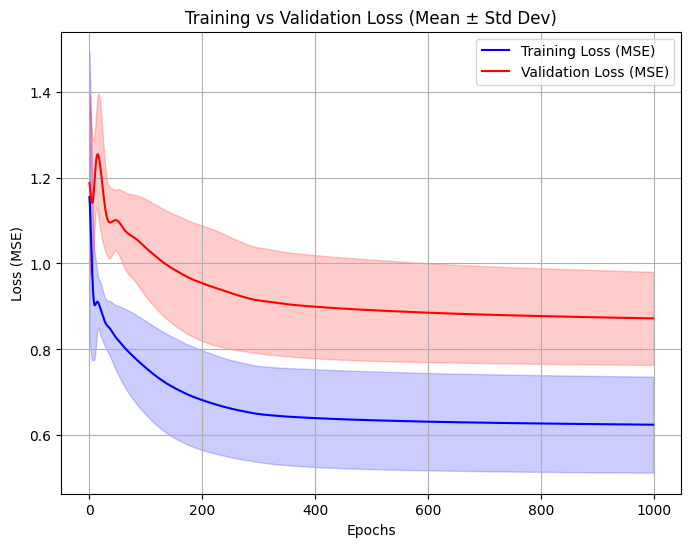

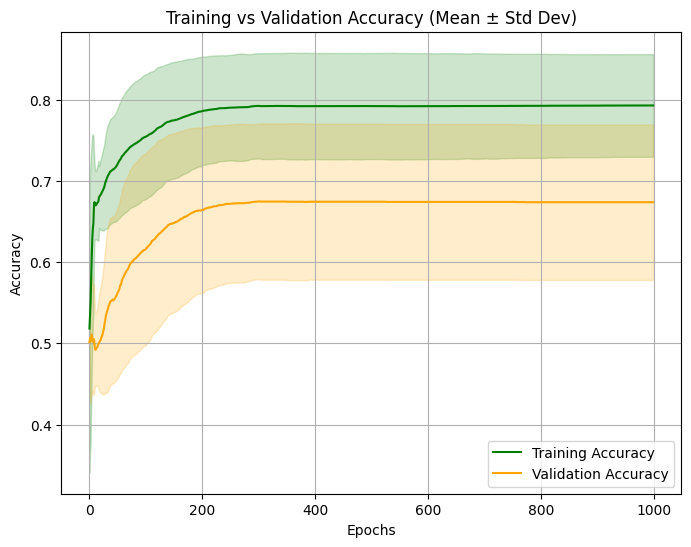


Running scenario: 20%-80% class A


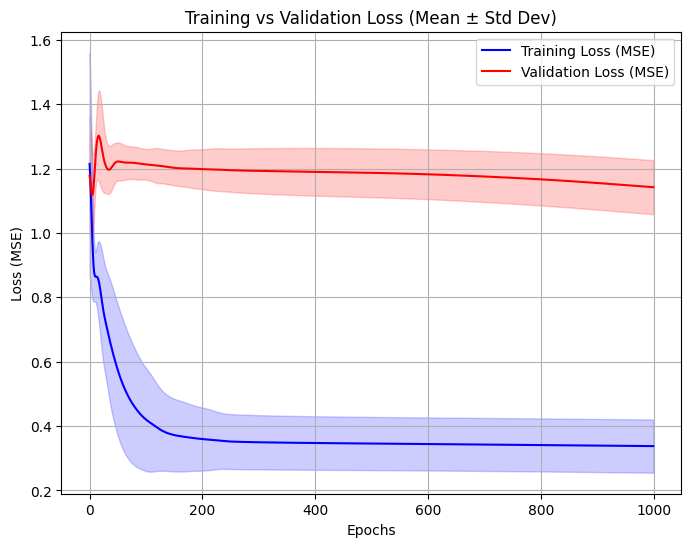

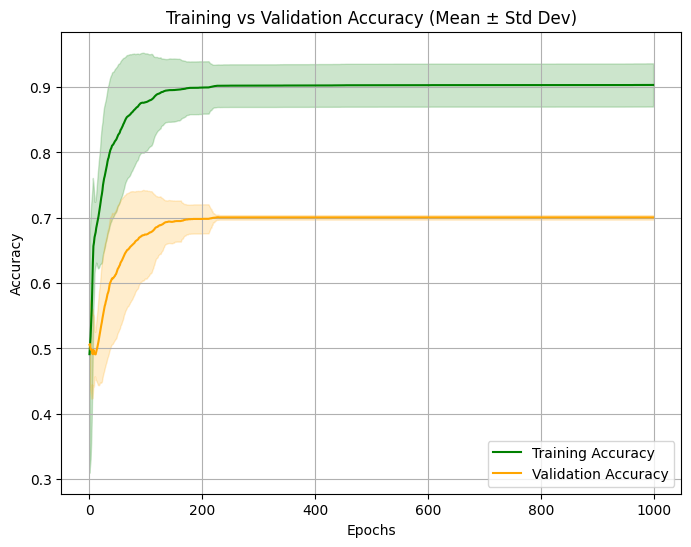

In [ ]:
# Generate dataset
classA, classB = generate_class_data(seed=42)
X, T = generate_data(classA, classB)

# Model parameters
hidden_size = 1
epochs = 1000
n_runs = 100

# Run multiple simulations for different subsampling methods
scenarios = ["25% each class", "50% class A", "20%-80% class A"]

for scenario in scenarios:
    print(f"\nRunning scenario: {scenario}")
    MSE_train, acc_train, MSE_val, acc_val = training_multiple_runs_split(
        TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha,
        X, T, epochs, n_runs, scenario)

    # Compute and plot the average loss across runs
    plot_average_metrics_split(MSE_train, acc_train, MSE_val, acc_val)


Running scenario: 25% each class


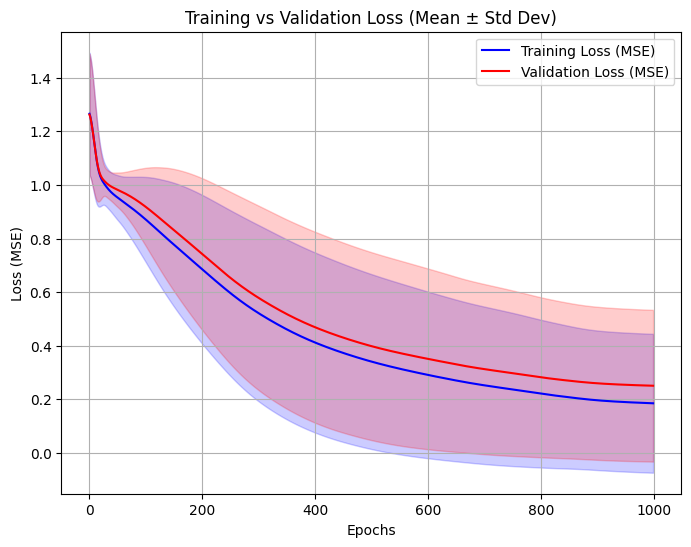

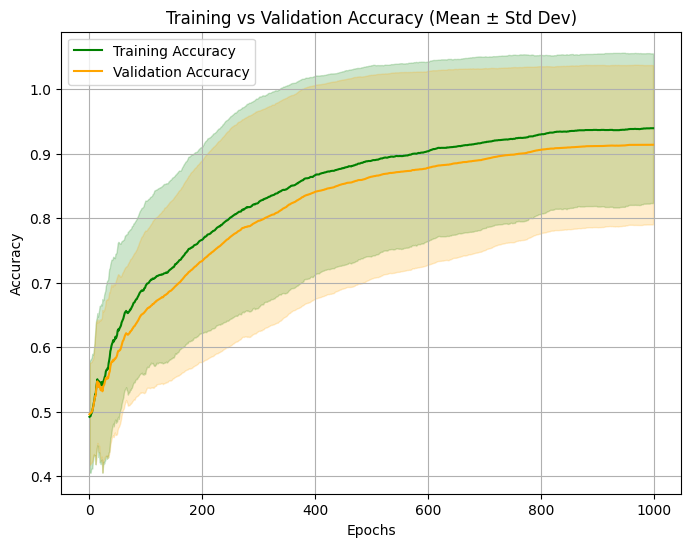


Running scenario: 50% class A


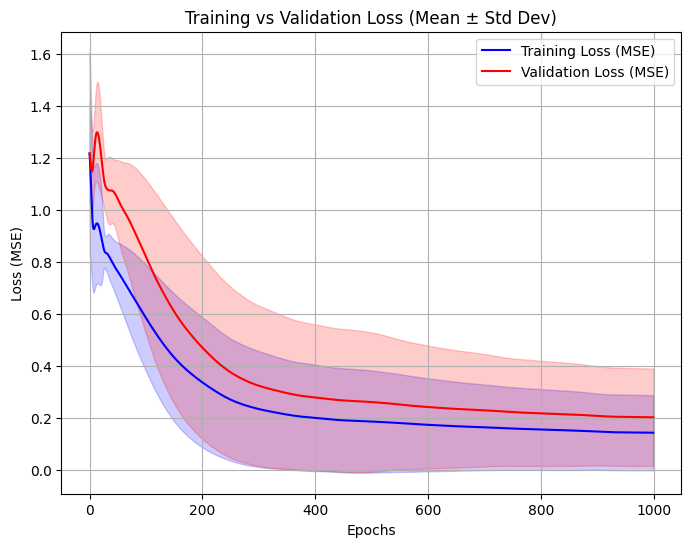

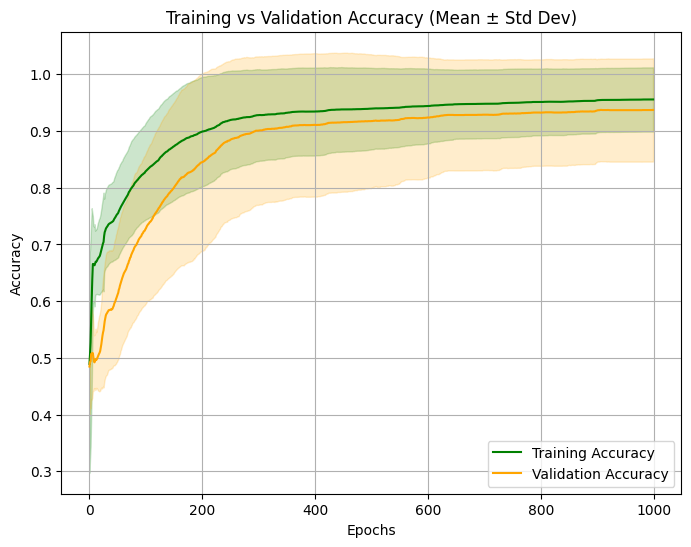


Running scenario: 20%-80% class A


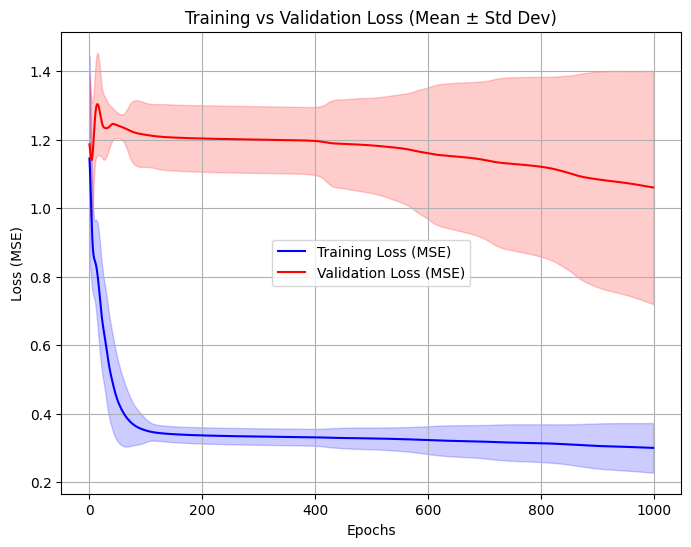

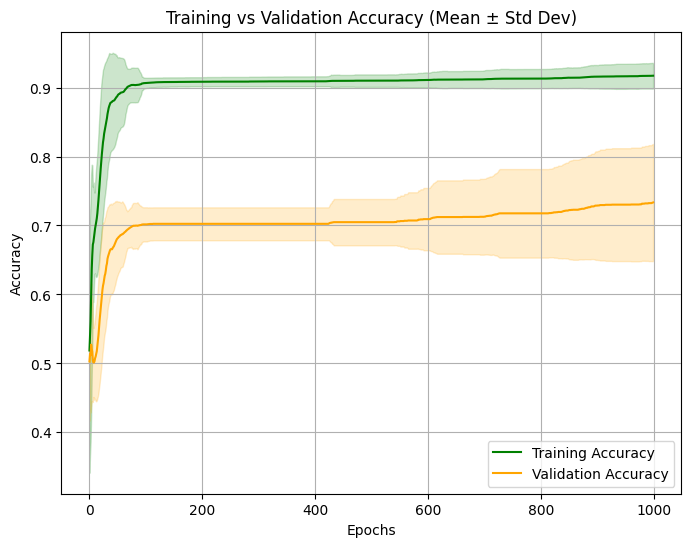

In [ ]:
# Model parameters
hidden_size = 2
epochs = 1000
n_runs = 100

# Run multiple simulations for different subsampling methods
scenarios = ["25% each class", "50% class A", "20%-80% class A"]

for scenario in scenarios:
    print(f"\nRunning scenario: {scenario}")
    MSE_train, acc_train, MSE_val, acc_val = training_multiple_runs_split(
        TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha,
        X, T, epochs, n_runs, scenario)

    # Compute and plot the average loss across runs
    plot_average_metrics_split(MSE_train, acc_train, MSE_val, acc_val)


Running scenario: 25% each class


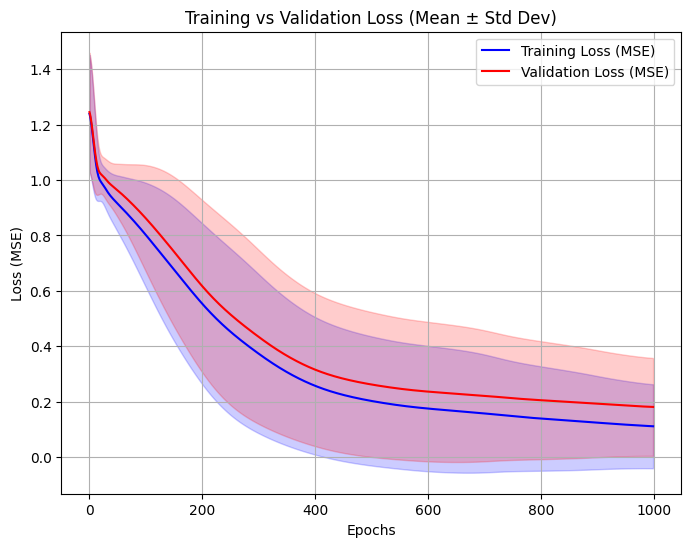

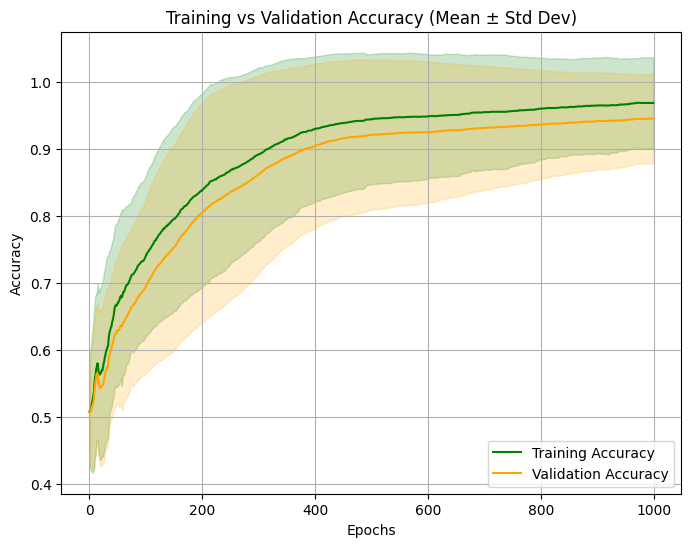


Running scenario: 50% class A


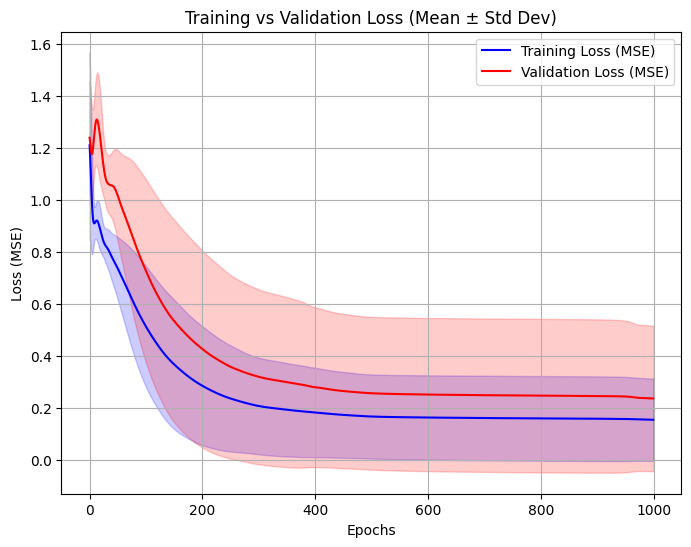

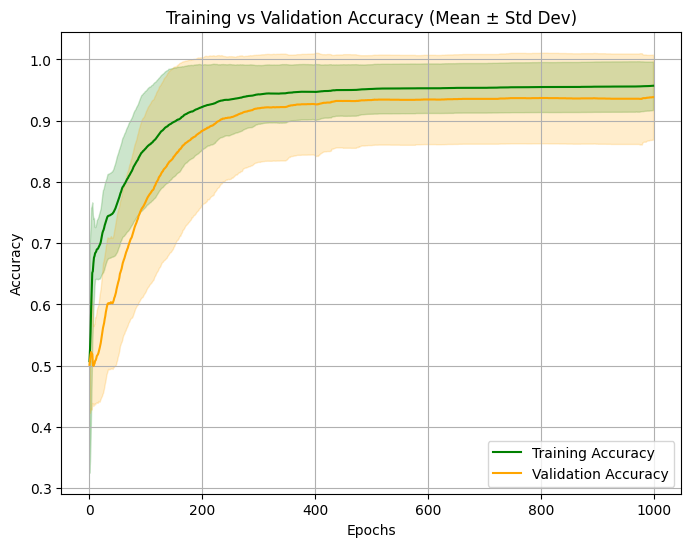


Running scenario: 20%-80% class A


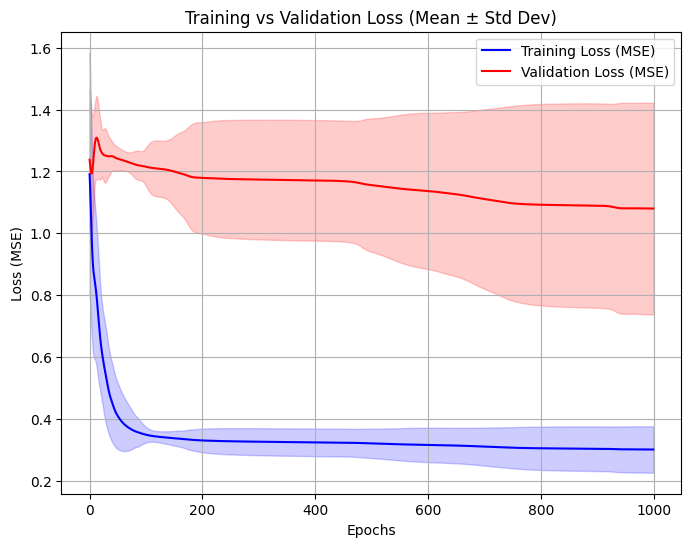

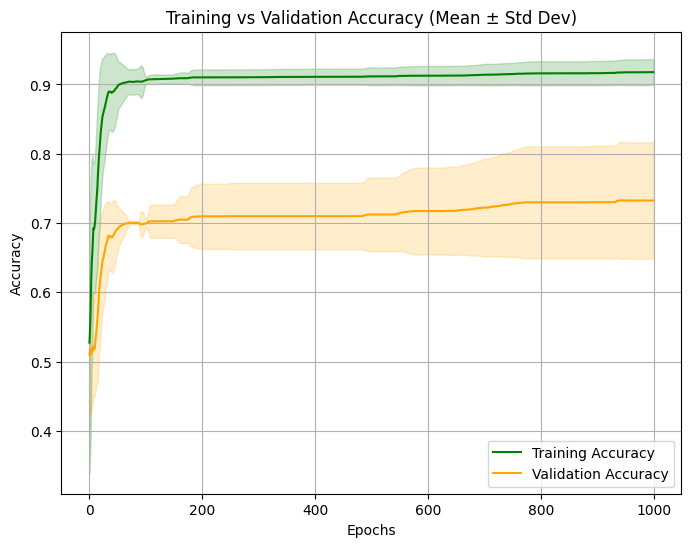

In [ ]:
# Model parameters
hidden_size = 3
epochs = 1000
n_runs = 100

# Run multiple simulations for different subsampling methods
scenarios = ["25% each class", "50% class A", "20%-80% class A"]

for scenario in scenarios:
    print(f"\nRunning scenario: {scenario}")
    MSE_train, acc_train, MSE_val, acc_val = training_multiple_runs_split(
        TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha,
        X, T, epochs, n_runs, scenario)

    # Compute and plot the average loss across runs
    plot_average_metrics_split(MSE_train, acc_train, MSE_val, acc_val)


Running scenario: 25% each class


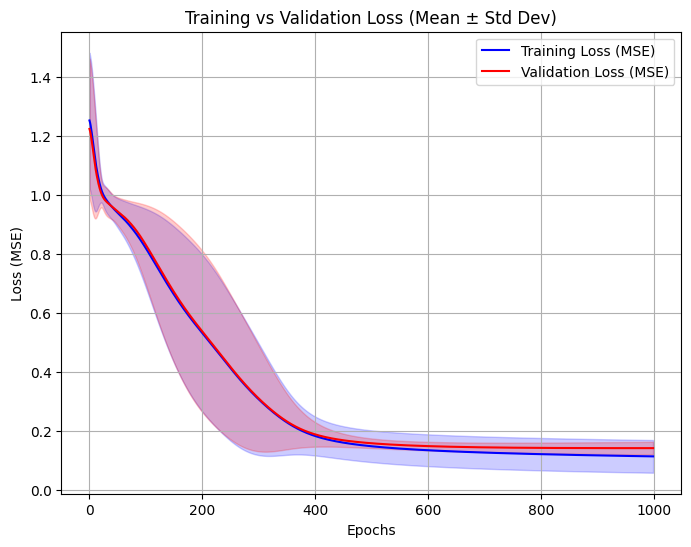

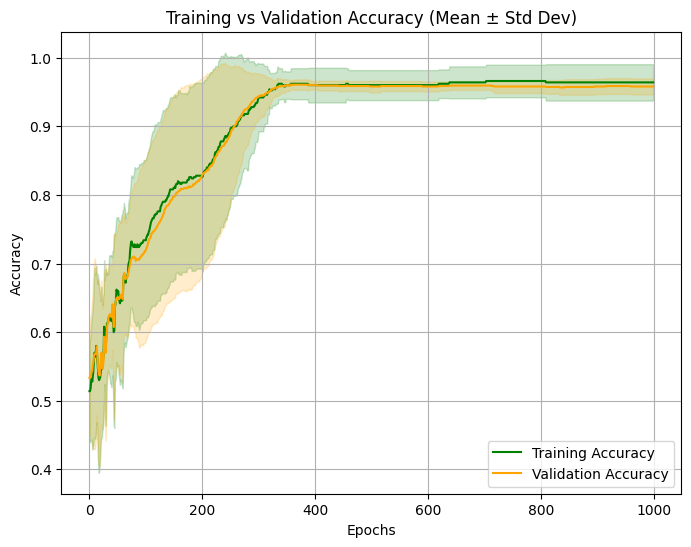


Running scenario: 50% class A


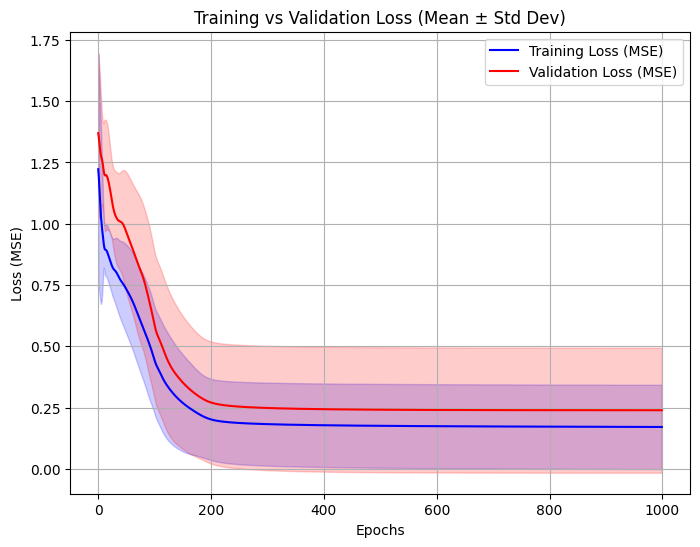

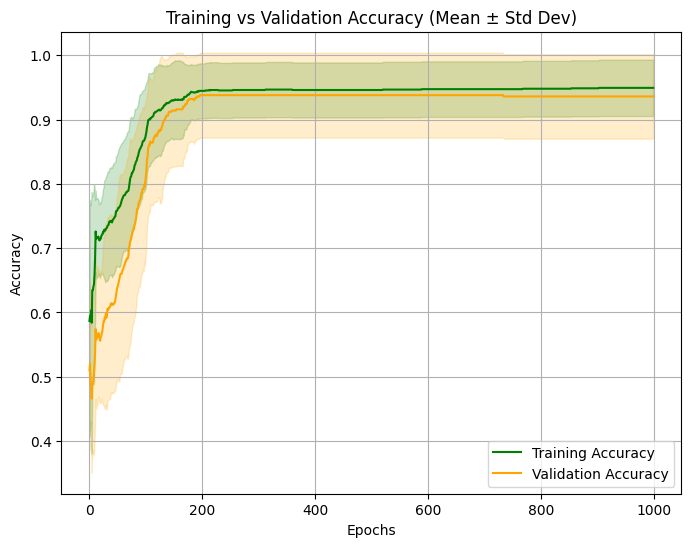


Running scenario: 20%-80% class A


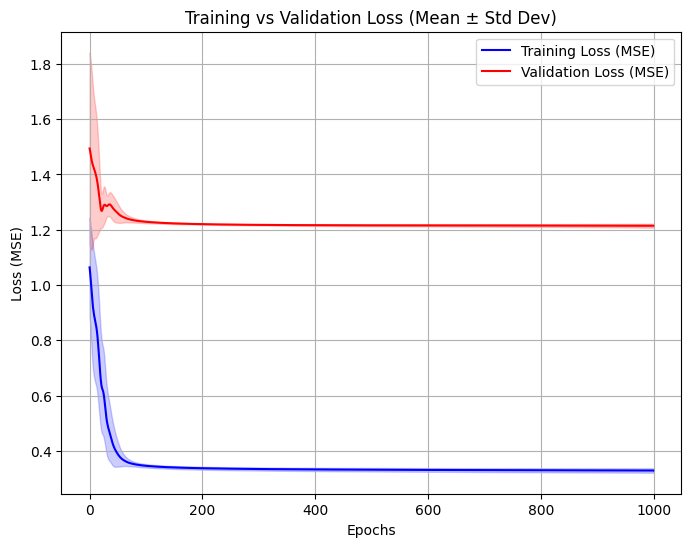

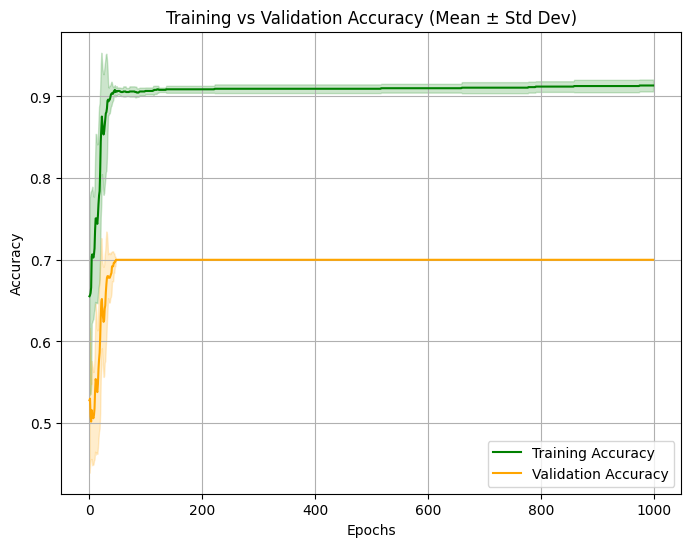

In [ ]:
# Model parameters
hidden_size = 4
epochs = 1000
n_runs = 10

# Run multiple simulations for different subsampling methods
scenarios = ["25% each class", "50% class A", "20%-80% class A"]

for scenario in scenarios:
    print(f"\nRunning scenario: {scenario}")
    MSE_train, acc_train, MSE_val, acc_val = training_multiple_runs_split(
        TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha,
        X, T, epochs, n_runs, scenario)

    # Compute and plot the average loss across runs
    plot_average_metrics_split(MSE_train, acc_train, MSE_val, acc_val)


Running scenario: 25% each class


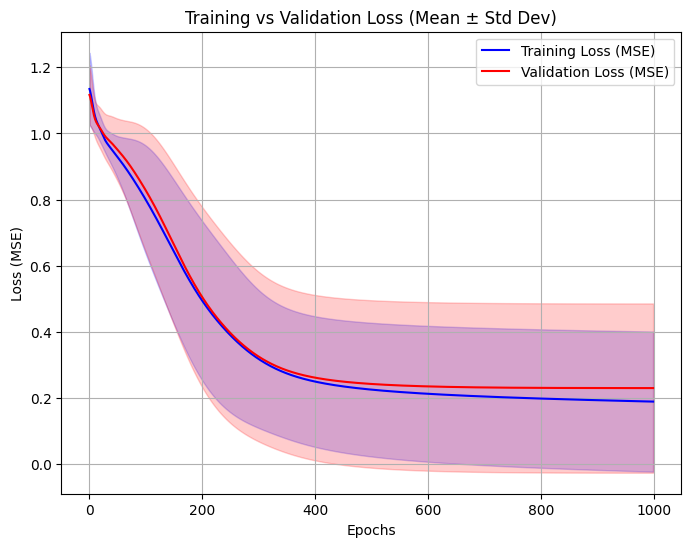

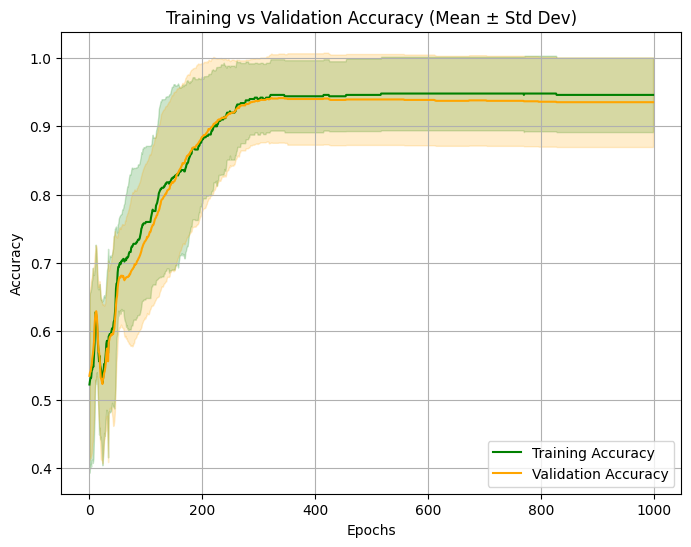


Running scenario: 50% class A


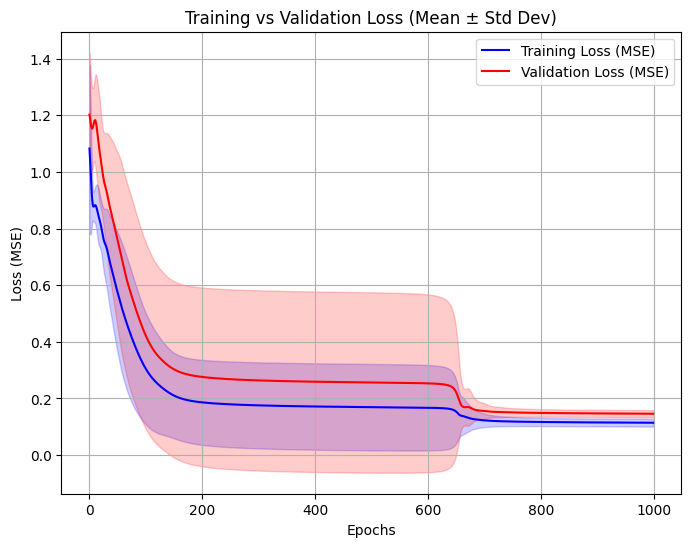

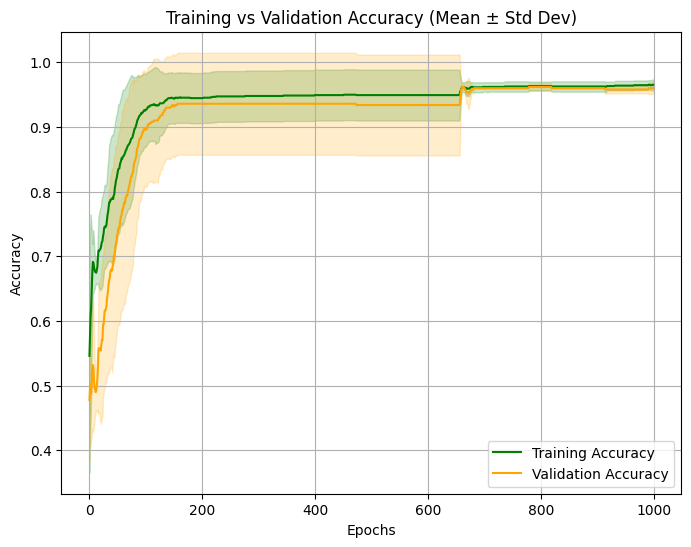


Running scenario: 20%-80% class A


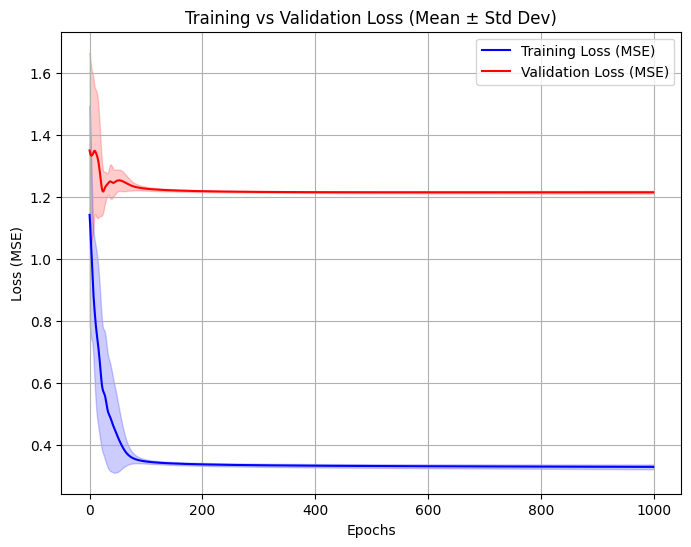

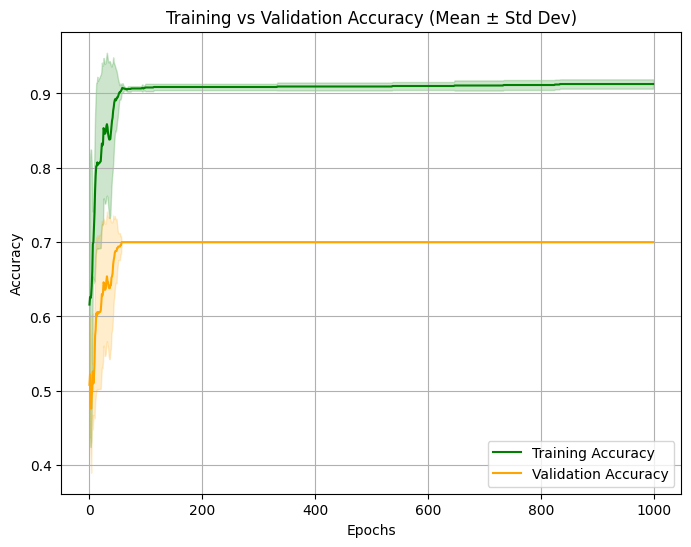

In [ ]:
# Model parameters
hidden_size = 5
epochs = 1000
n_runs = 10

# Run multiple simulations for different subsampling methods
scenarios = ["25% each class", "50% class A", "20%-80% class A"]

for scenario in scenarios:
    print(f"\nRunning scenario: {scenario}")
    MSE_train, acc_train, MSE_val, acc_val = training_multiple_runs_split(
        TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha,
        X, T, epochs, n_runs, scenario)

    # Compute and plot the average loss across runs
    plot_average_metrics_split(MSE_train, acc_train, MSE_val, acc_val)


Running scenario: 25% each class


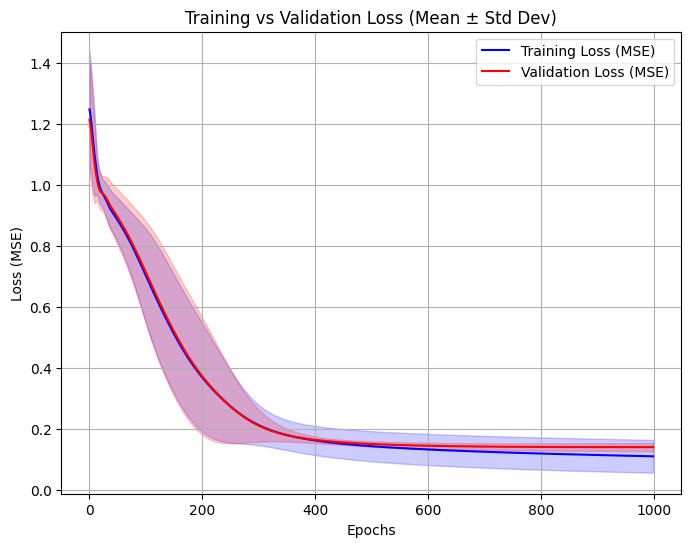

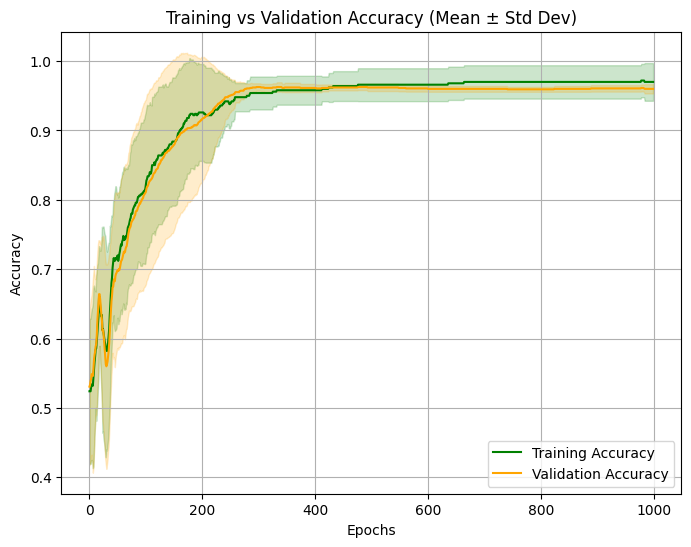


Running scenario: 50% class A


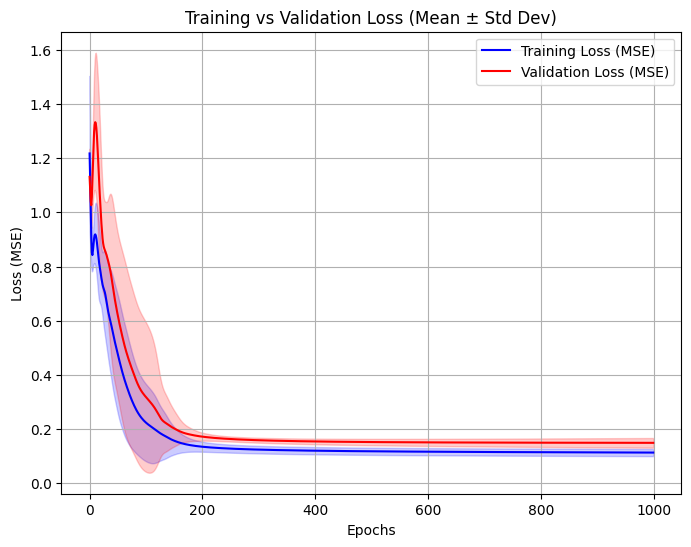

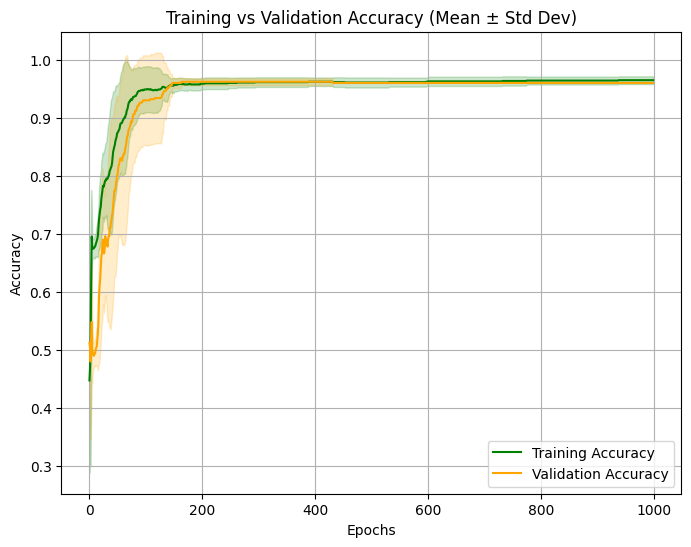


Running scenario: 20%-80% class A


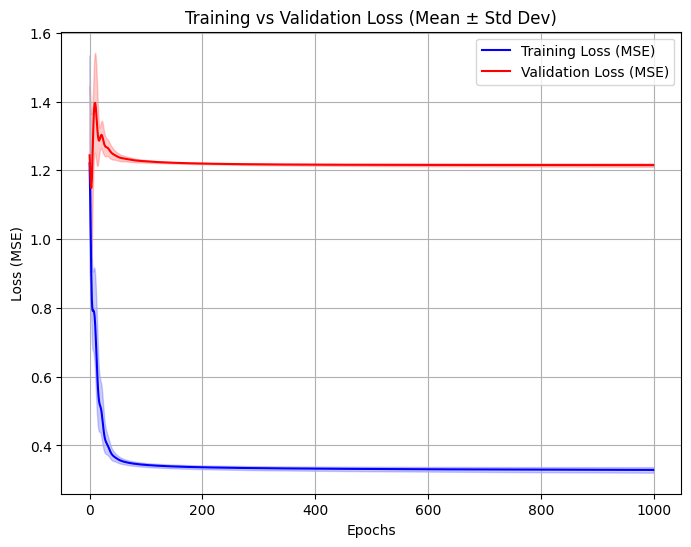

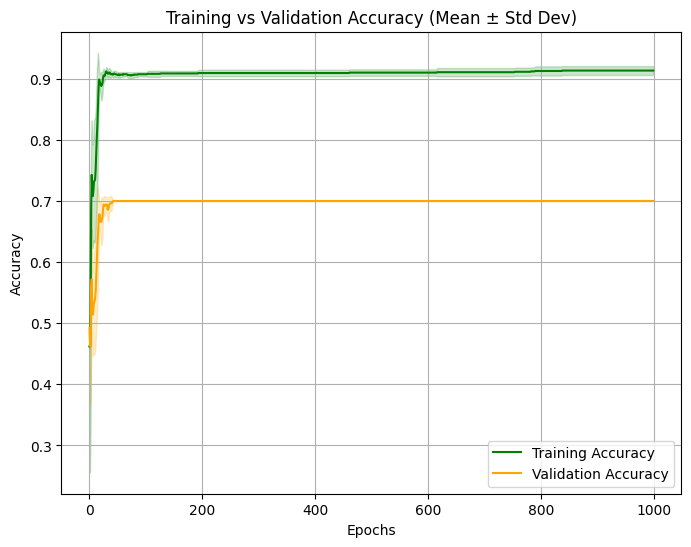

In [ ]:
# Model parameters
hidden_size = 6
epochs = 1000
n_runs = 10

# Run multiple simulations for different subsampling methods
scenarios = ["25% each class", "50% class A", "20%-80% class A"]

for scenario in scenarios:
    print(f"\nRunning scenario: {scenario}")
    MSE_train, acc_train, MSE_val, acc_val = training_multiple_runs_split(
        TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha,
        X, T, epochs, n_runs, scenario)

    # Compute and plot the average loss across runs
    plot_average_metrics_split(MSE_train, acc_train, MSE_val, acc_val)


Running scenario: 25% each class


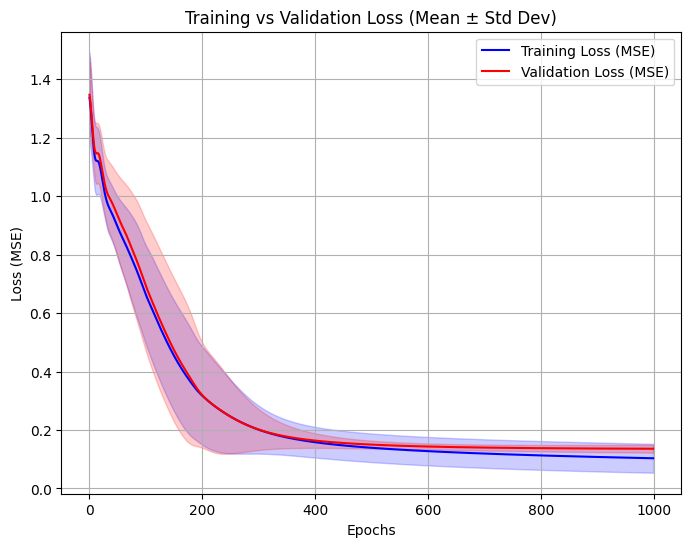

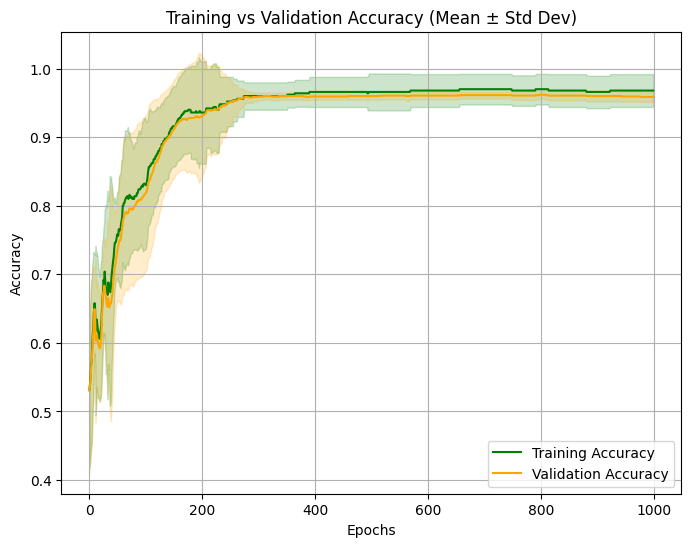


Running scenario: 50% class A


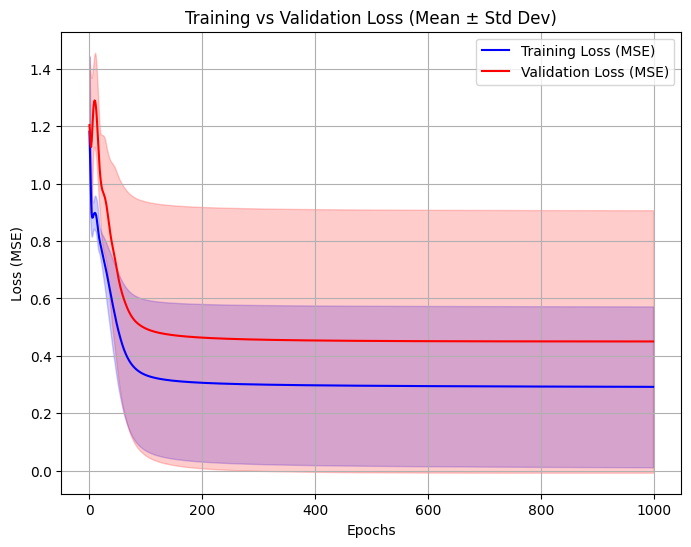

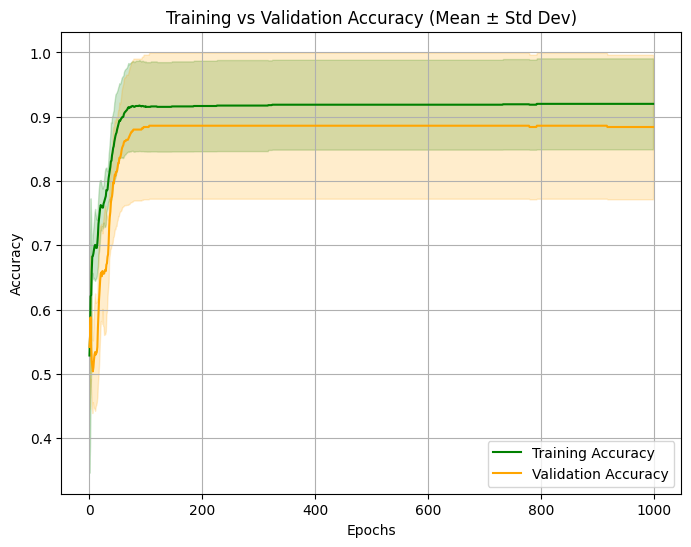


Running scenario: 20%-80% class A


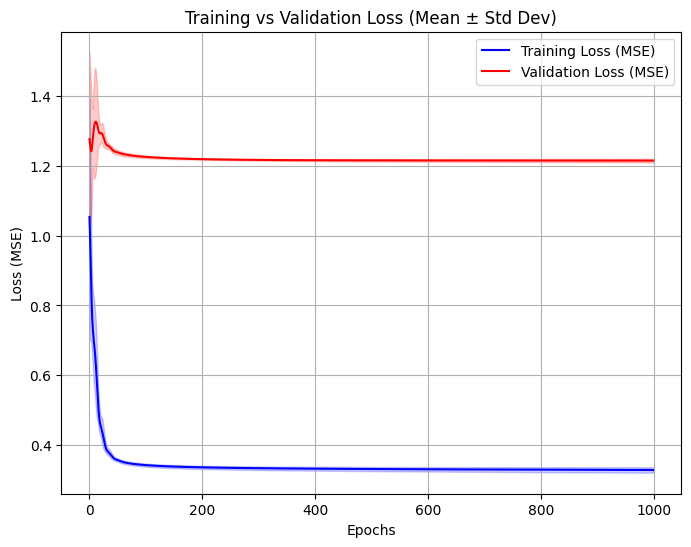

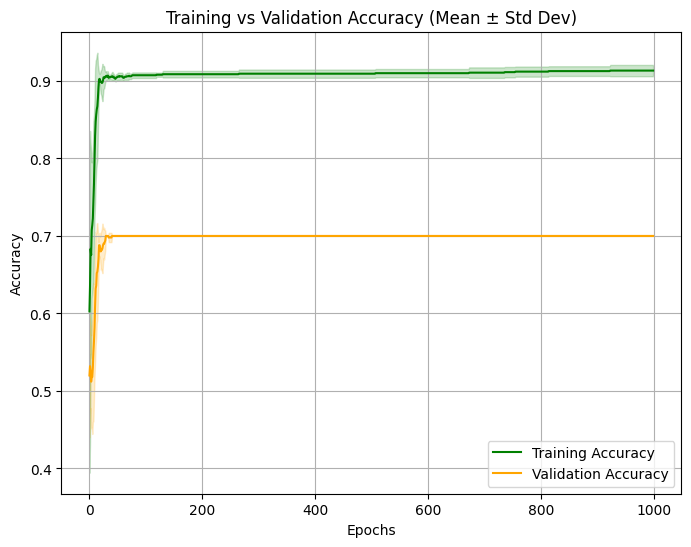

In [ ]:
# Model parameters
hidden_size = 7
epochs = 1000
n_runs = 10

# Run multiple simulations for different subsampling methods
scenarios = ["25% each class", "50% class A", "20%-80% class A"]

for scenario in scenarios:
    print(f"\nRunning scenario: {scenario}")
    MSE_train, acc_train, MSE_val, acc_val = training_multiple_runs_split(
        TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha,
        X, T, epochs, n_runs, scenario)

    # Compute and plot the average loss across runs
    plot_average_metrics_split(MSE_train, acc_train, MSE_val, acc_val)


Running scenario: 25% each class


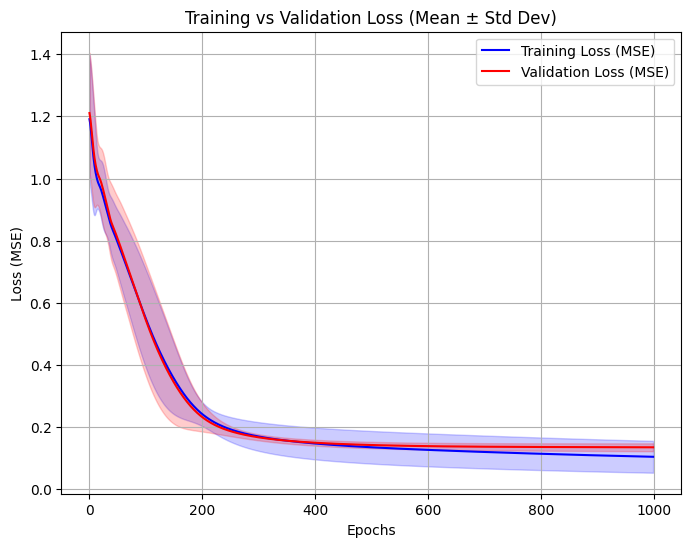

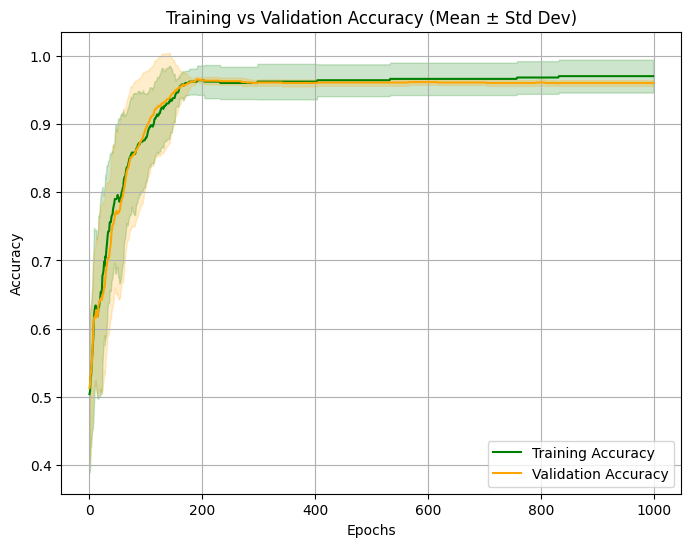


Running scenario: 50% class A


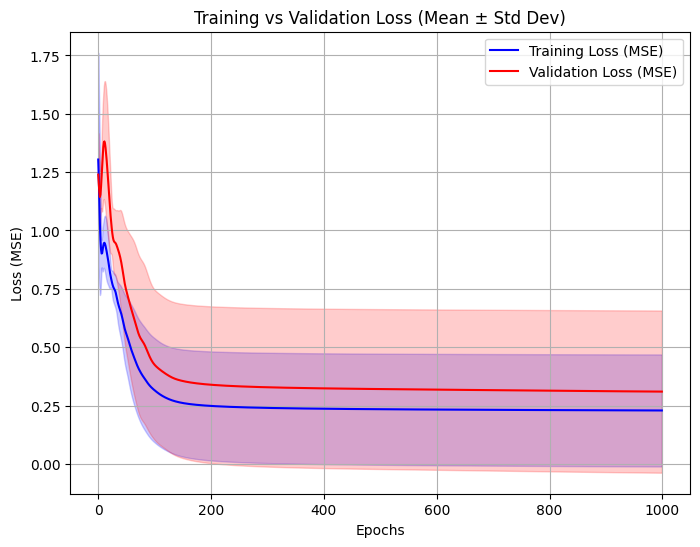

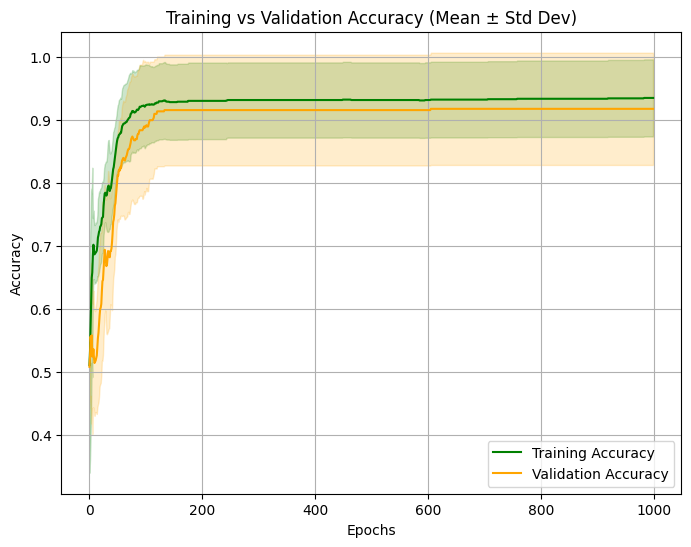


Running scenario: 20%-80% class A


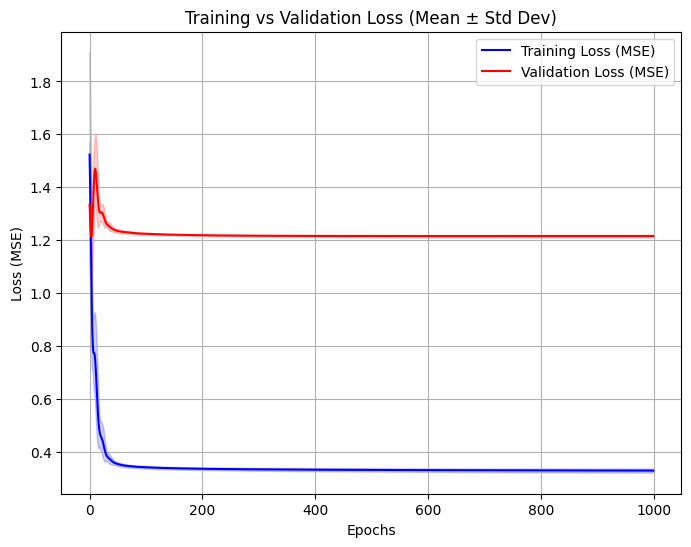

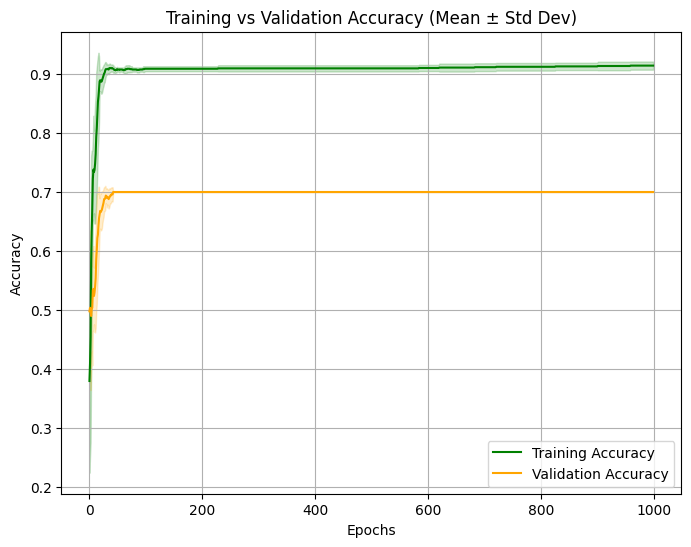

In [ ]:
# Model parameters
hidden_size = 8
epochs = 1000
n_runs = 10

# Run multiple simulations for different subsampling methods
scenarios = ["25% each class", "50% class A", "20%-80% class A"]

for scenario in scenarios:
    print(f"\nRunning scenario: {scenario}")
    MSE_train, acc_train, MSE_val, acc_val = training_multiple_runs_split(
        TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha,
        X, T, epochs, n_runs, scenario)

    # Compute and plot the average loss across runs
    plot_average_metrics_split(MSE_train, acc_train, MSE_val, acc_val)


Running scenario: 25% each class


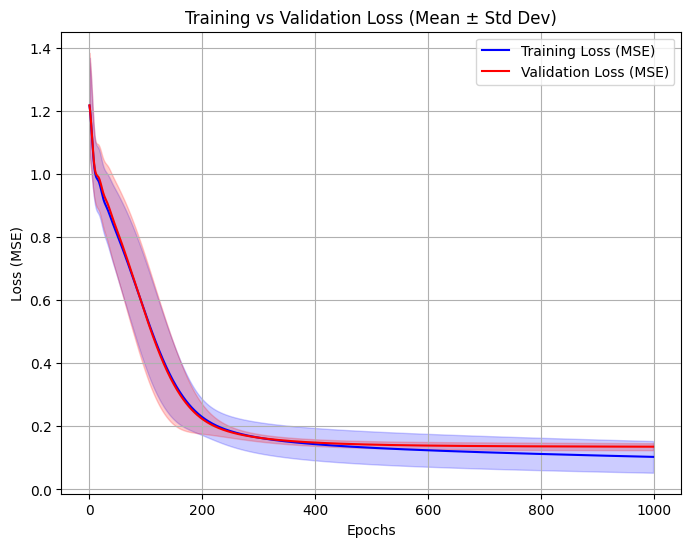

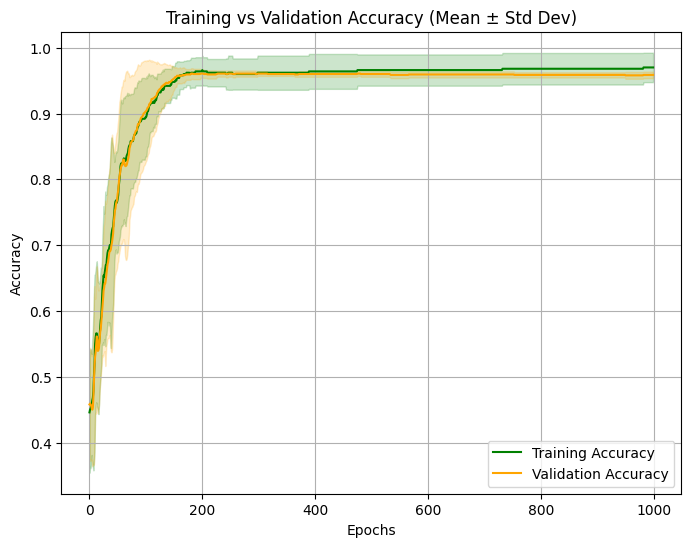


Running scenario: 50% class A


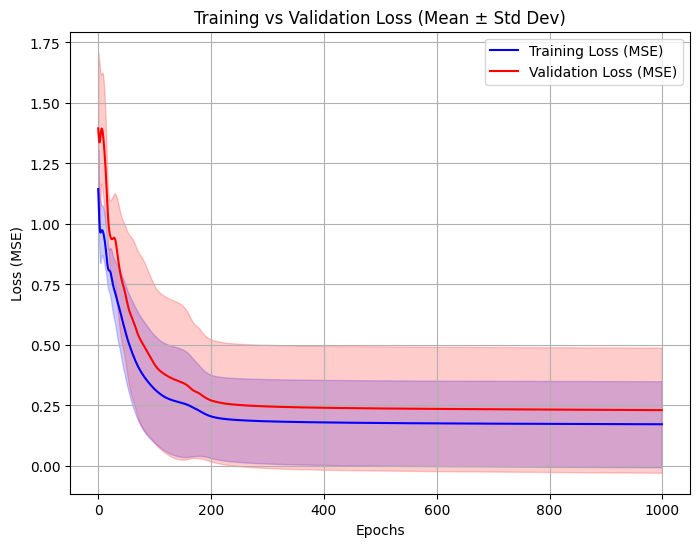

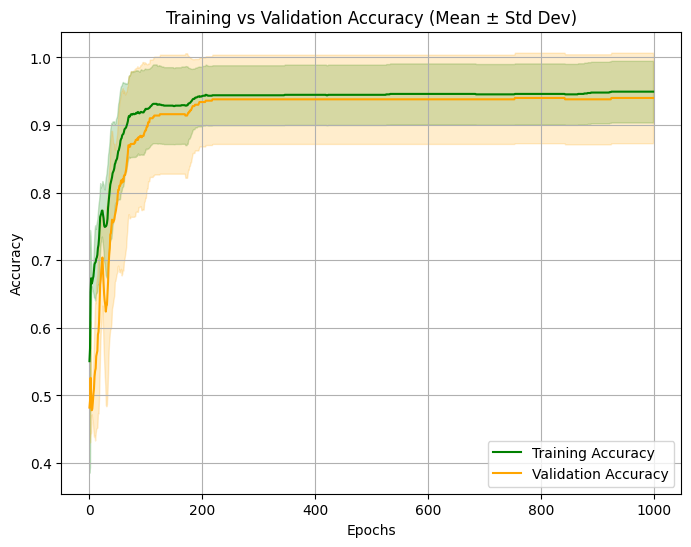


Running scenario: 20%-80% class A


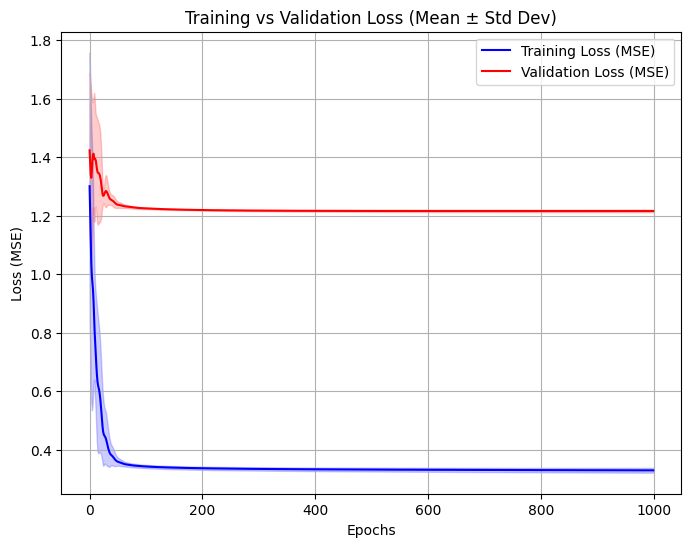

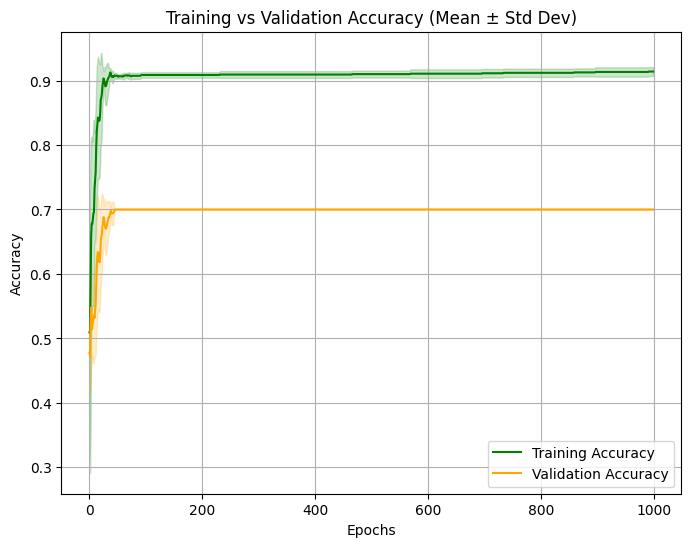

In [ ]:
# Model parameters
hidden_size = 9
epochs = 1000
n_runs = 10

# Run multiple simulations for different subsampling methods
scenarios = ["25% each class", "50% class A", "20%-80% class A"]

for scenario in scenarios:
    print(f"\nRunning scenario: {scenario}")
    MSE_train, acc_train, MSE_val, acc_val = training_multiple_runs_split(
        TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha,
        X, T, epochs, n_runs, scenario)

    # Compute and plot the average loss across runs
    plot_average_metrics_split(MSE_train, acc_train, MSE_val, acc_val)


Running scenario: 25% each class


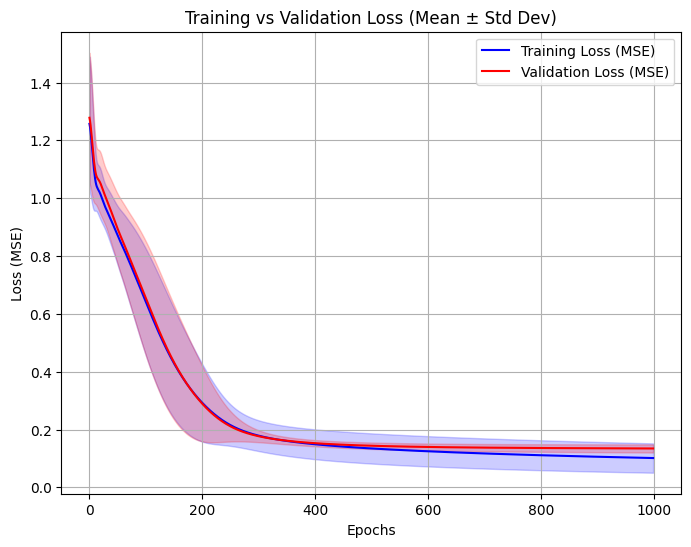

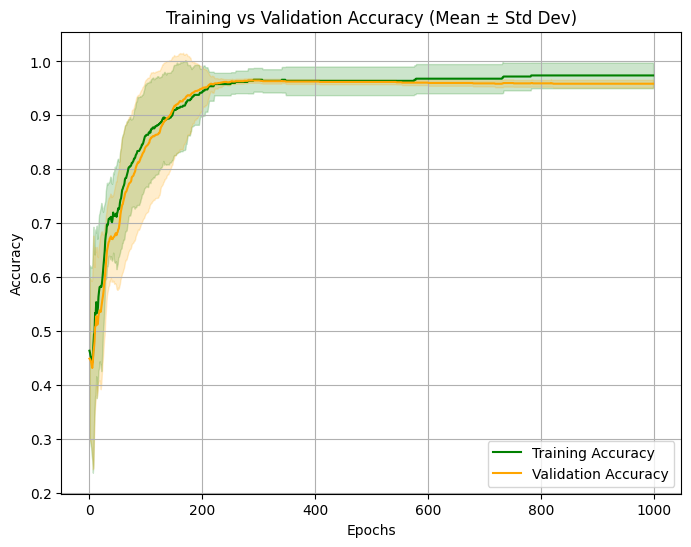


Running scenario: 50% class A


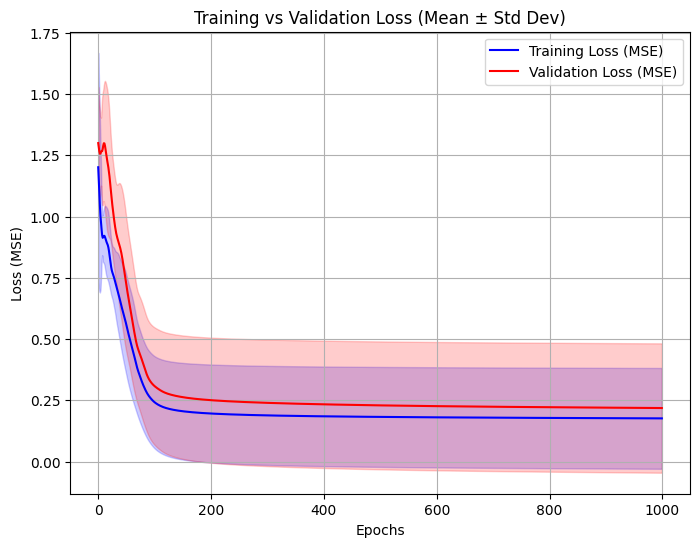

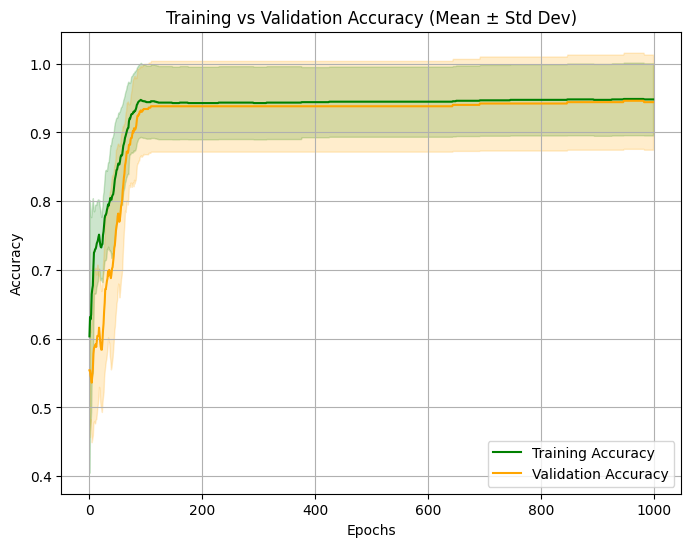


Running scenario: 20%-80% class A


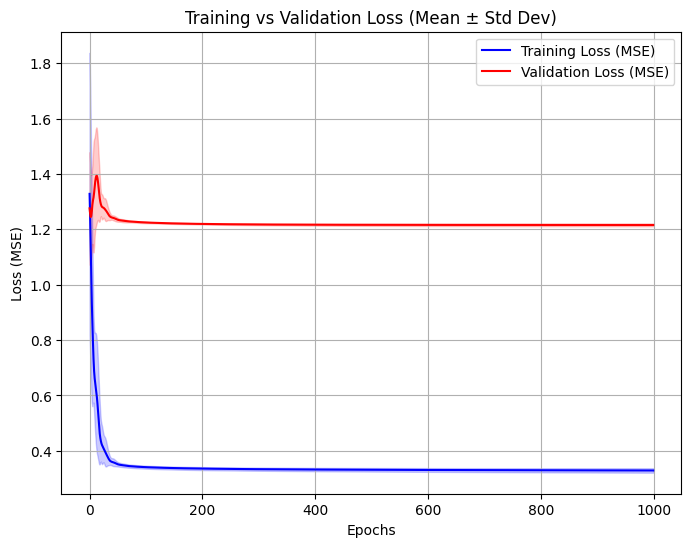

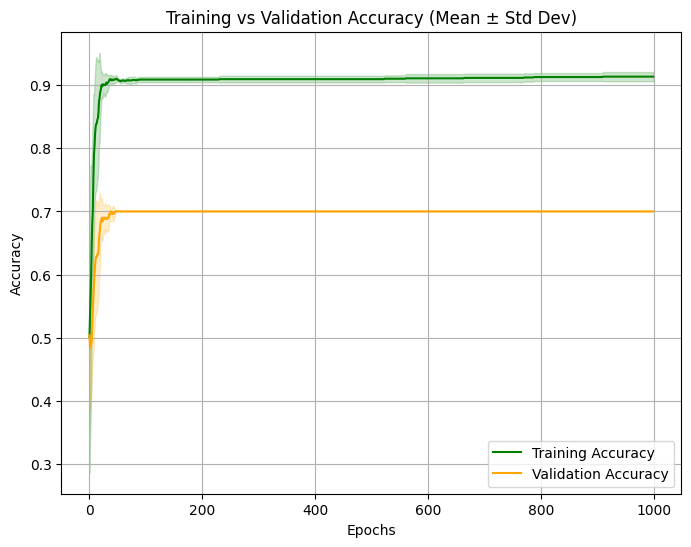

In [ ]:
# Model parameters
hidden_size = 10
epochs = 1000
n_runs = 10

# Run multiple simulations for different subsampling methods
scenarios = ["25% each class", "50% class A", "20%-80% class A"]

for scenario in scenarios:
    print(f"\nRunning scenario: {scenario}")
    MSE_train, acc_train, MSE_val, acc_val = training_multiple_runs_split(
        TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha,
        X, T, epochs, n_runs, scenario)

    # Compute and plot the average loss across runs
    plot_average_metrics_split(MSE_train, acc_train, MSE_val, acc_val)


Running scenario: 25% each class


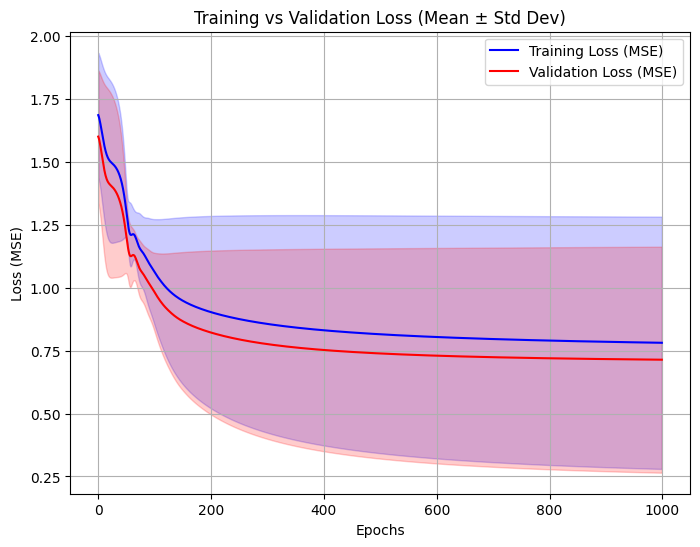

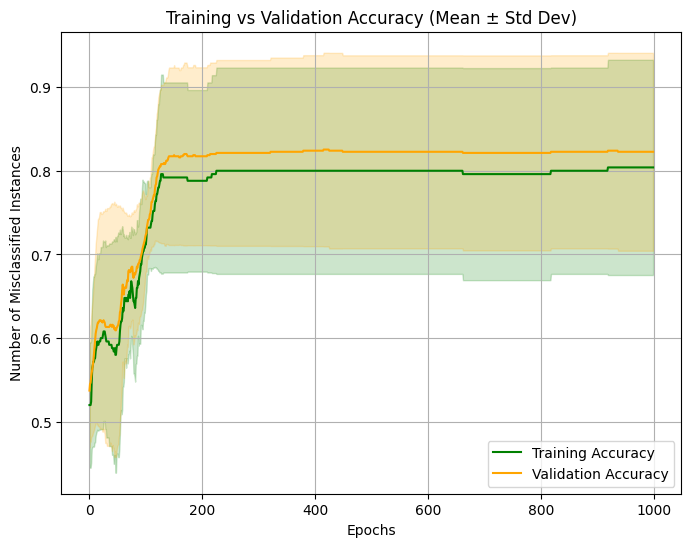


Running scenario: 50% class A


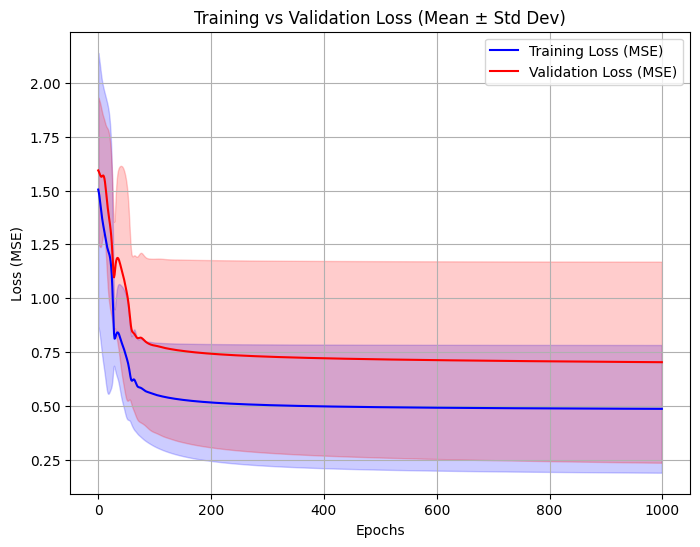

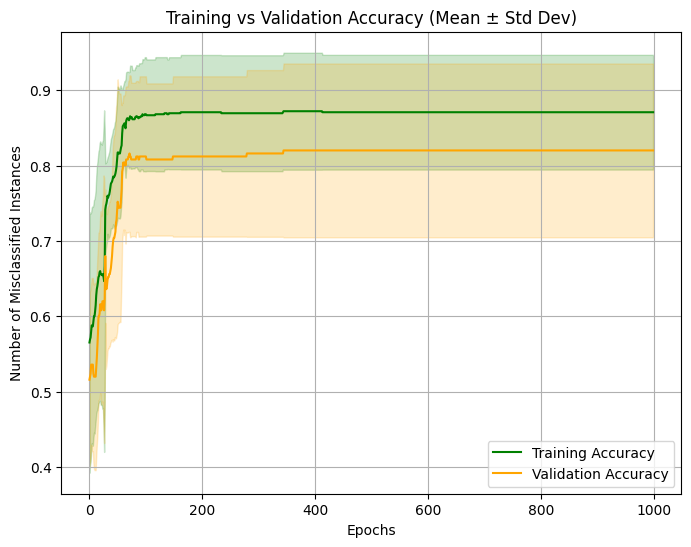


Running scenario: 20%-80% class A


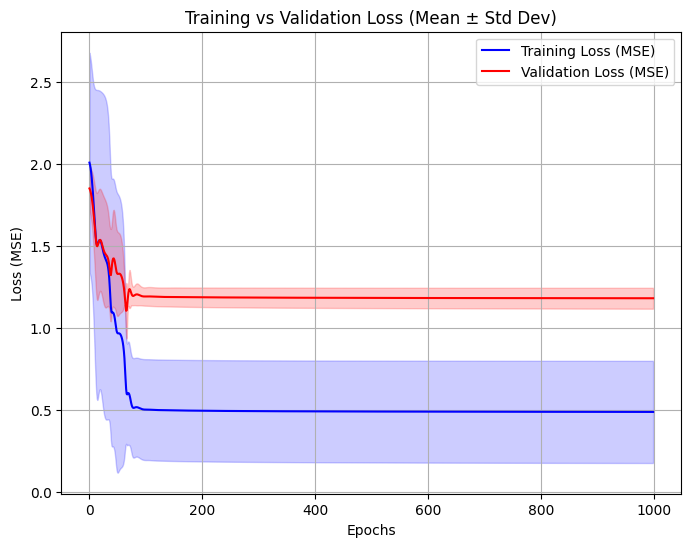

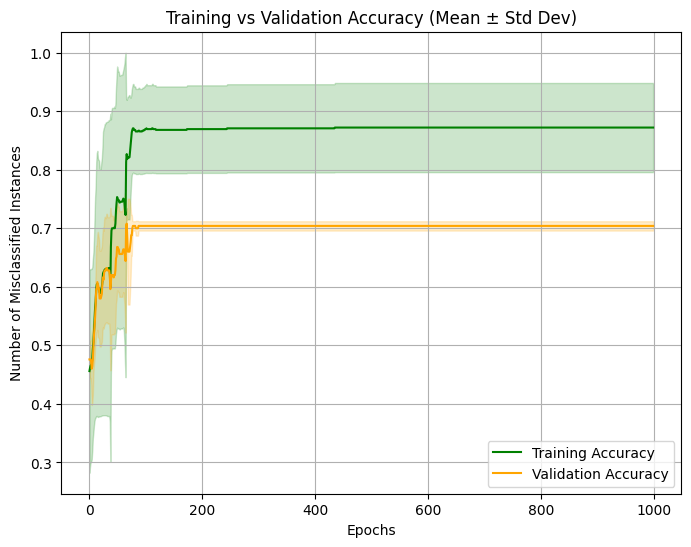

In [ ]:
# Model parameters
lr = 0.001 # lower lr for complex models
hidden_size = 100
epochs = 1000
n_runs = 5

# Run multiple simulations for different subsampling methods
scenarios = ["25% each class", "50% class A", "20%-80% class A"]

for scenario in scenarios:
    print(f"\nRunning scenario: {scenario}")
    MSE_train, acc_train, MSE_val, acc_val = training_multiple_runs_split(
        TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha,
        X, T, epochs, n_runs, scenario)

    # Compute and plot the average loss across runs
    plot_average_metrics_split(MSE_train, acc_train, MSE_val, acc_val)

Batch learning vs Sequential learning

Using seed: 42

Running scenario: 25% each class


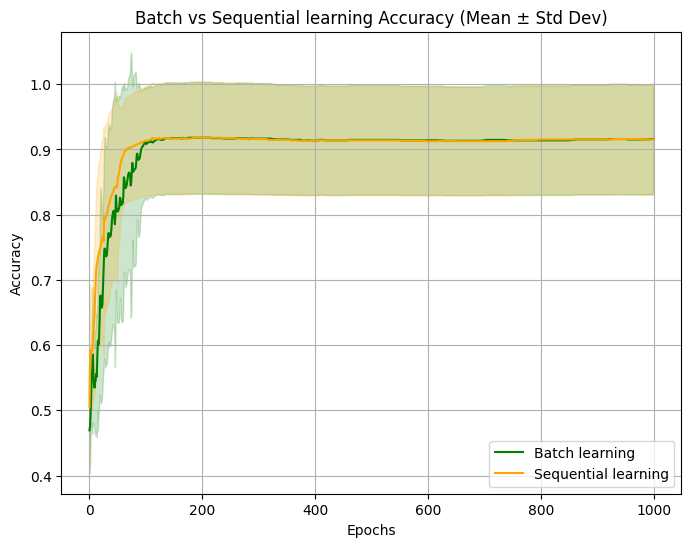


Running scenario: 50% class A


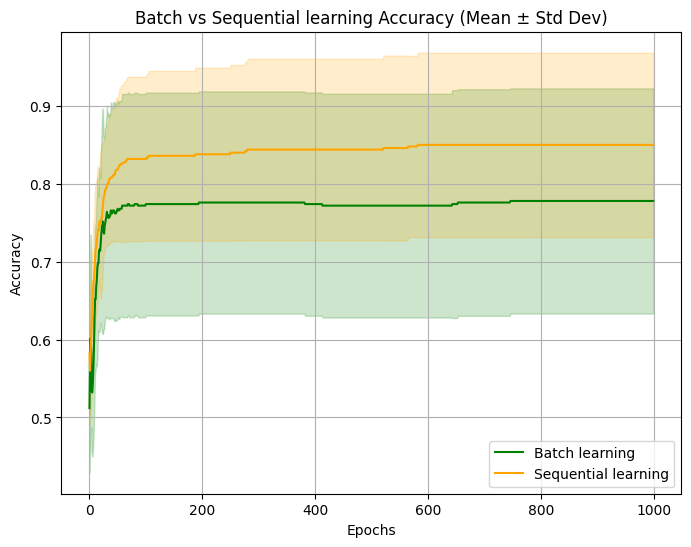


Running scenario: 20%-80% class A


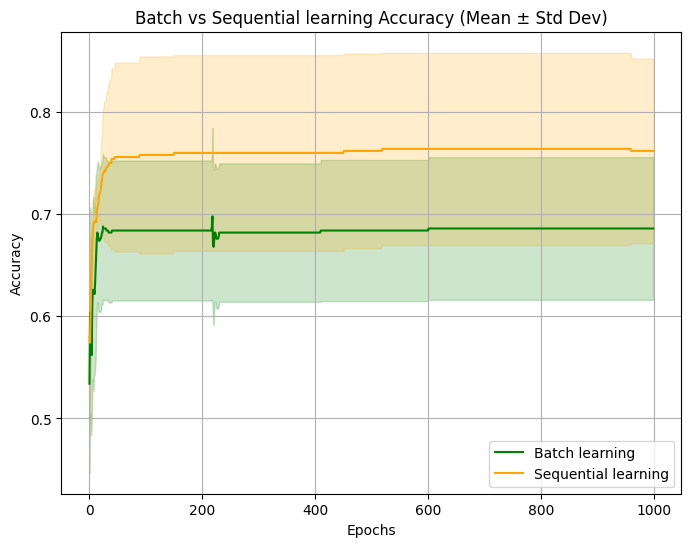

In [ ]:
# Generate data that is not linearly separable
classA, classB = generate_class_data(seed=seed)
X, T = generate_data(classA, classB)

# Sequential and Batch models
n_runs = 10
lr = 0.01
hidden_size = 50
epochs = 1000

# Run multiple simulations for different subsampling methods
scenarios = ["25% each class", "50% class A", "20%-80% class A"]

for scenario in scenarios:
    print(f"\nRunning scenario: {scenario}")
    X_train, T_train, X_val, T_val = subsample_data(X, T, scenario)
    all_acc_val_batch = training_multiple_runs_split(TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs, scenario)[-1]
    all_acc_val_seq = training_multiple_runs_split_sequential(TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs, scenario)[-1]

    # Call the function after training
    plot_batch_vs_seq(all_acc_val_batch, all_acc_val_seq)

### Decision Boundary


Running scenario: 25% each class


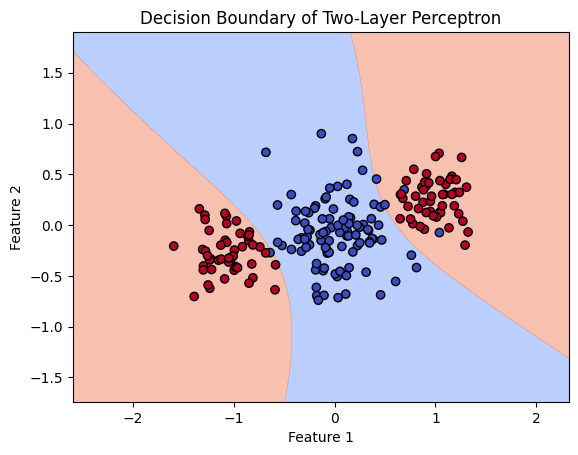


Running scenario: 50% class A


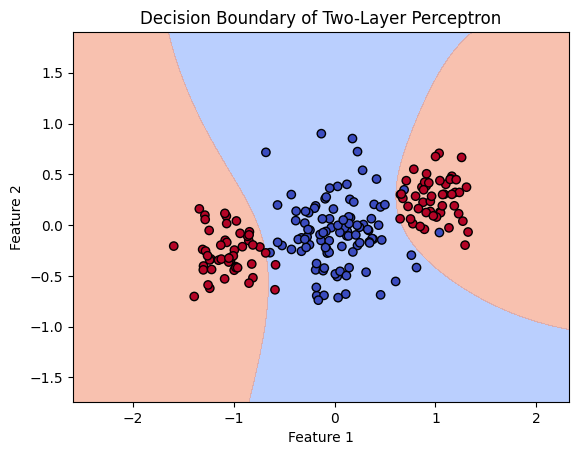


Running scenario: 20%-80% class A


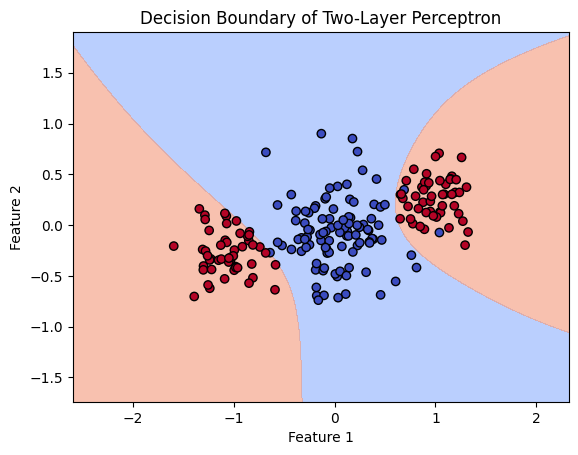

In [ ]:
# Generate data that is not linearly separable
classA, classB = generate_class_data(seed=seed)
X, T = generate_data(classA, classB)

lr = 0.01
hidden_size = 100
epochs = 1000
model = TwoLayerPerceptron(input_size, output_size, hidden_size, lr, alpha)

# Generate a mesh grid spanning the input space
def plot_decision_boundary(model, X, T, resolution=100):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))

    # Flatten the grid points and predict
    grid_points = np.vstack([xx.ravel(), yy.ravel()])
    predictions = model.forward(grid_points).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, predictions, levels=[-1, 0, 1], cmap='coolwarm', alpha=0.6)

    # Scatter plot of training data
    plt.scatter(X[0, :], X[1, :], c=T.ravel(), cmap='coolwarm', edgecolors='k')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary of Two-Layer Perceptron')
    plt.show()

# Run multiple simulations for different subsampling methods
scenarios = ["25% each class", "50% class A", "20%-80% class A"]

for scenario in scenarios:
    print(f"\nRunning scenario: {scenario}")
    X_train, T_train, X_val, T_val = subsample_data(X, T, scenario)
    training_validation(model, X_train, T_train, X_val, T_val, epochs)

    # Call the function after training
    plot_decision_boundary(model, X, T)


Running scenario: 25% each class


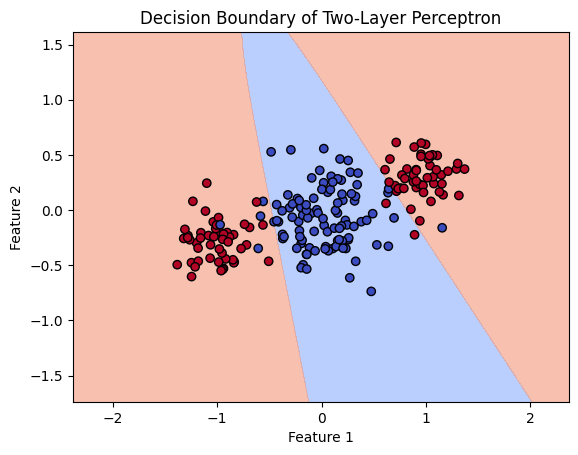


Running scenario: 50% class A


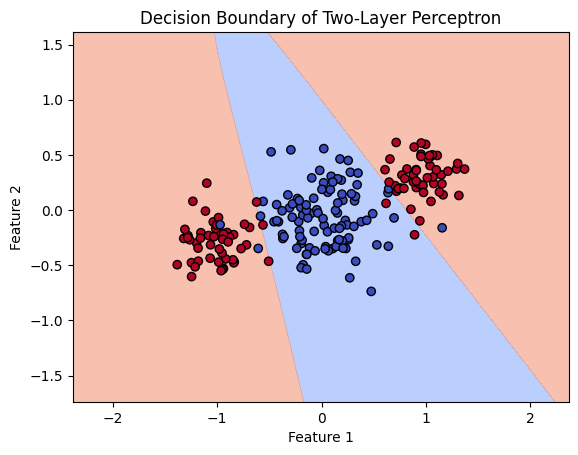


Running scenario: 20%-80% class A


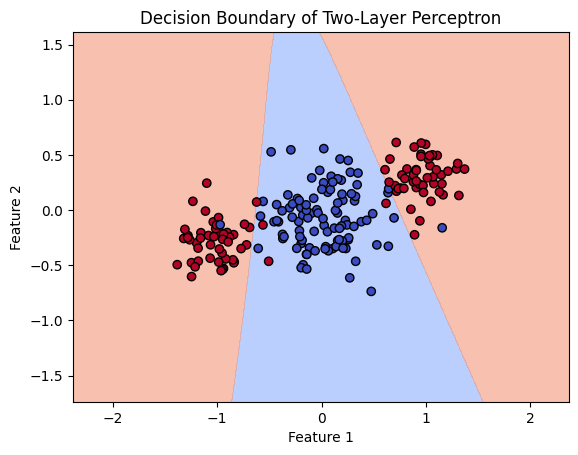

In [ ]:
lr = 0.01
hidden_size = 6
epochs = 1000
model = TwoLayerPerceptron(input_size, output_size, hidden_size, lr, alpha)

# Run multiple simulations for different subsampling methods
scenarios = ["25% each class", "50% class A", "20%-80% class A"]

for scenario in scenarios:
    print(f"\nRunning scenario: {scenario}")
    X_train, T_train, X_val, T_val = subsample_data(X, T, scenario)
    training_validation(model, X_train, T_train, X_val, T_val, epochs)

    # Call the function after training
    plot_decision_boundary(model, X, T)

## 2) Function approximation


Training with 1 hidden units...
Epoch 0, MSE: 0.11902
Epoch 20, MSE: 0.06905
Epoch 40, MSE: 0.06779
Epoch 60, MSE: 0.06745
Epoch 80, MSE: 0.06724
Epoch 100, MSE: 0.06703
Epoch 120, MSE: 0.06679
Epoch 140, MSE: 0.06652
Epoch 160, MSE: 0.06624
Epoch 180, MSE: 0.06595
Epoch 200, MSE: 0.06565
Epoch 220, MSE: 0.06535
Epoch 240, MSE: 0.06505
Epoch 260, MSE: 0.06475
Epoch 280, MSE: 0.06445
Epoch 300, MSE: 0.06417
Epoch 320, MSE: 0.06390
Epoch 340, MSE: 0.06364
Epoch 360, MSE: 0.06340
Epoch 380, MSE: 0.06318
Epoch 400, MSE: 0.06297
Epoch 420, MSE: 0.06278
Epoch 440, MSE: 0.06260
Epoch 460, MSE: 0.06243
Epoch 480, MSE: 0.06228
Epoch 500, MSE: 0.06214
Epoch 520, MSE: 0.06201
Epoch 540, MSE: 0.06189
Epoch 560, MSE: 0.06178
Epoch 580, MSE: 0.06168
Epoch 600, MSE: 0.06158
Epoch 620, MSE: 0.06150
Epoch 640, MSE: 0.06142
Epoch 660, MSE: 0.06134
Epoch 680, MSE: 0.06127
Epoch 700, MSE: 0.06121
Epoch 720, MSE: 0.06115
Epoch 740, MSE: 0.06109
Epoch 760, MSE: 0.06104
Epoch 780, MSE: 0.06099
Epoch 800, MS

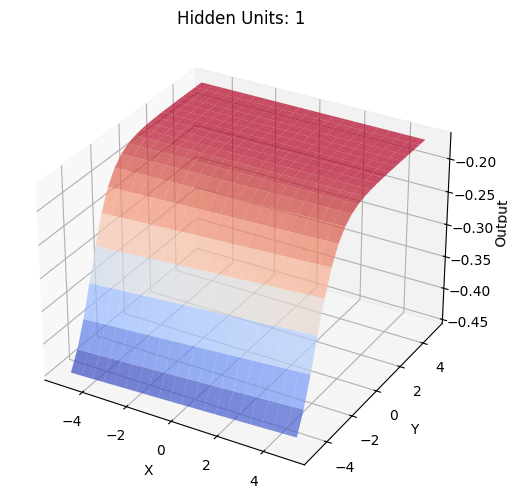


Training with 5 hidden units...
Epoch 0, MSE: 0.15581
Epoch 20, MSE: 0.07244
Epoch 40, MSE: 0.06212
Epoch 60, MSE: 0.05203
Epoch 80, MSE: 0.04329
Epoch 100, MSE: 0.04172
Epoch 120, MSE: 0.04117
Epoch 140, MSE: 0.04088
Epoch 160, MSE: 0.04072
Epoch 180, MSE: 0.04061
Epoch 200, MSE: 0.04045
Epoch 220, MSE: 0.04011
Epoch 240, MSE: 0.03909
Epoch 260, MSE: 0.03610
Epoch 280, MSE: 0.03008
Epoch 300, MSE: 0.01457
Epoch 320, MSE: 0.00809
Epoch 340, MSE: 0.00614
Epoch 360, MSE: 0.00549
Epoch 380, MSE: 0.00520
Epoch 400, MSE: 0.00507
Epoch 420, MSE: 0.00499
Epoch 440, MSE: 0.00495
Epoch 460, MSE: 0.00491
Epoch 480, MSE: 0.00489
Epoch 500, MSE: 0.00487
Epoch 520, MSE: 0.00485
Epoch 540, MSE: 0.00484
Epoch 560, MSE: 0.00482
Epoch 580, MSE: 0.00481
Epoch 600, MSE: 0.00479
Epoch 620, MSE: 0.00478
Epoch 640, MSE: 0.00477
Epoch 660, MSE: 0.00476
Epoch 680, MSE: 0.00475
Epoch 700, MSE: 0.00474
Epoch 720, MSE: 0.00473
Epoch 740, MSE: 0.00472
Epoch 760, MSE: 0.00471
Epoch 780, MSE: 0.00470
Epoch 800, MS

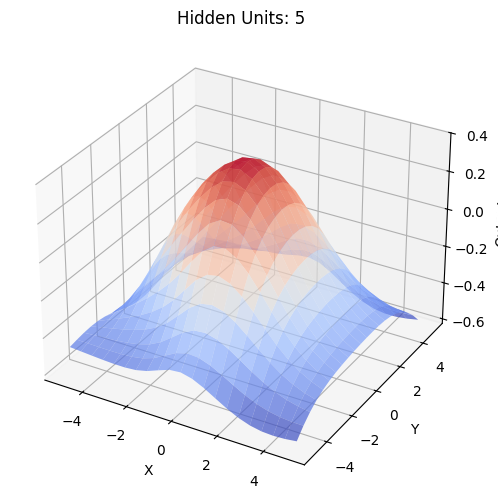


Training with 10 hidden units...
Epoch 0, MSE: 0.70991
Epoch 20, MSE: 0.09105
Epoch 40, MSE: 0.05210
Epoch 60, MSE: 0.03909
Epoch 80, MSE: 0.02835
Epoch 100, MSE: 0.01363
Epoch 120, MSE: 0.00937
Epoch 140, MSE: 0.00750
Epoch 160, MSE: 0.00595
Epoch 180, MSE: 0.00481
Epoch 200, MSE: 0.00414
Epoch 220, MSE: 0.00377
Epoch 240, MSE: 0.00353
Epoch 260, MSE: 0.00336
Epoch 280, MSE: 0.00324
Epoch 300, MSE: 0.00315
Epoch 320, MSE: 0.00308
Epoch 340, MSE: 0.00302
Epoch 360, MSE: 0.00298
Epoch 380, MSE: 0.00296
Epoch 400, MSE: 0.00293
Epoch 420, MSE: 0.00291
Epoch 440, MSE: 0.00290
Epoch 460, MSE: 0.00289
Epoch 480, MSE: 0.00288
Epoch 500, MSE: 0.00287
Epoch 520, MSE: 0.00286
Epoch 540, MSE: 0.00285
Epoch 560, MSE: 0.00285
Epoch 580, MSE: 0.00284
Epoch 600, MSE: 0.00283
Epoch 620, MSE: 0.00283
Epoch 640, MSE: 0.00282
Epoch 660, MSE: 0.00282
Epoch 680, MSE: 0.00282
Epoch 700, MSE: 0.00281
Epoch 720, MSE: 0.00281
Epoch 740, MSE: 0.00280
Epoch 760, MSE: 0.00280
Epoch 780, MSE: 0.00280
Epoch 800, M

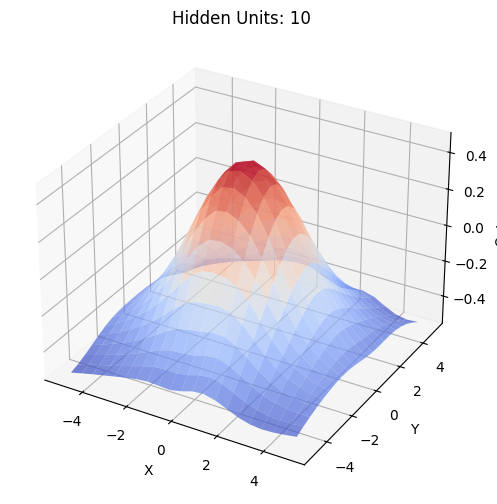


Training with 20 hidden units...
Epoch 0, MSE: 0.70096
Epoch 20, MSE: 0.10047
Epoch 40, MSE: 0.01298
Epoch 60, MSE: 0.00546
Epoch 80, MSE: 0.00387
Epoch 100, MSE: 0.00339
Epoch 120, MSE: 0.00318
Epoch 140, MSE: 0.00307
Epoch 160, MSE: 0.00299
Epoch 180, MSE: 0.00294
Epoch 200, MSE: 0.00290
Epoch 220, MSE: 0.00286
Epoch 240, MSE: 0.00284
Epoch 260, MSE: 0.00281
Epoch 280, MSE: 0.00279
Epoch 300, MSE: 0.00278
Epoch 320, MSE: 0.00276
Epoch 340, MSE: 0.00275
Epoch 360, MSE: 0.00274
Epoch 380, MSE: 0.00273
Epoch 400, MSE: 0.00272
Epoch 420, MSE: 0.00271
Epoch 440, MSE: 0.00270
Epoch 460, MSE: 0.00269
Epoch 480, MSE: 0.00269
Epoch 500, MSE: 0.00268
Epoch 520, MSE: 0.00267
Epoch 540, MSE: 0.00267
Epoch 560, MSE: 0.00266
Epoch 580, MSE: 0.00266
Epoch 600, MSE: 0.00265
Epoch 620, MSE: 0.00265
Epoch 640, MSE: 0.00265
Epoch 660, MSE: 0.00264
Epoch 680, MSE: 0.00264
Epoch 700, MSE: 0.00263
Epoch 720, MSE: 0.00263
Epoch 740, MSE: 0.00263
Epoch 760, MSE: 0.00262
Epoch 780, MSE: 0.00262
Epoch 800, M

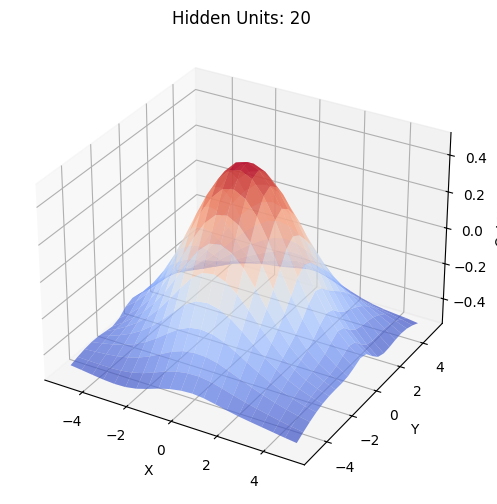


Training with 25 hidden units...
Epoch 0, MSE: 0.33816
Epoch 20, MSE: 0.04174
Epoch 40, MSE: 0.00885
Epoch 60, MSE: 0.00577
Epoch 80, MSE: 0.00477
Epoch 100, MSE: 0.00427
Epoch 120, MSE: 0.00395
Epoch 140, MSE: 0.00372
Epoch 160, MSE: 0.00354
Epoch 180, MSE: 0.00340
Epoch 200, MSE: 0.00328
Epoch 220, MSE: 0.00319
Epoch 240, MSE: 0.00311
Epoch 260, MSE: 0.00305
Epoch 280, MSE: 0.00299
Epoch 300, MSE: 0.00295
Epoch 320, MSE: 0.00291
Epoch 340, MSE: 0.00287
Epoch 360, MSE: 0.00285
Epoch 380, MSE: 0.00282
Epoch 400, MSE: 0.00280
Epoch 420, MSE: 0.00278
Epoch 440, MSE: 0.00276
Epoch 460, MSE: 0.00275
Epoch 480, MSE: 0.00274
Epoch 500, MSE: 0.00273
Epoch 520, MSE: 0.00272
Epoch 540, MSE: 0.00271
Epoch 560, MSE: 0.00270
Epoch 580, MSE: 0.00269
Epoch 600, MSE: 0.00269
Epoch 620, MSE: 0.00268
Epoch 640, MSE: 0.00268
Epoch 660, MSE: 0.00267
Epoch 680, MSE: 0.00267
Epoch 700, MSE: 0.00266
Epoch 720, MSE: 0.00266
Epoch 740, MSE: 0.00266
Epoch 760, MSE: 0.00265
Epoch 780, MSE: 0.00265
Epoch 800, M

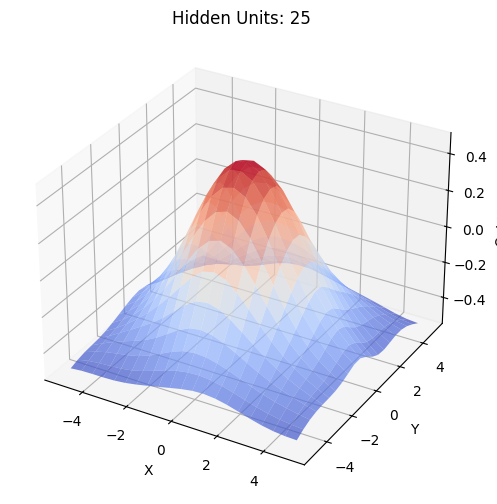

In [ ]:
# Generate function data
def generate_gaussian_data(grid_size=21, noise=0.0):
    x = np.linspace(-5, 5, grid_size)
    y = np.linspace(-5, 5, grid_size)
    xx, yy = np.meshgrid(x, y)

    # Gaussian function
    zz = np.exp(-0.1 * (xx ** 2 + yy ** 2)) - 0.5

    # Convert to training format
    X = np.vstack([xx.ravel(), yy.ravel()])  # 2xndata
    T = zz.ravel() + noise * np.random.randn(*zz.ravel().shape)  # Add noise

    return X, T, x, y, zz

def visualize_results(model, X, x, y, title="Approximation"):
    out = model.forward(X).reshape(len(x), len(y))
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    xx, yy = np.meshgrid(x, y)
    ax.plot_surface(xx, yy, out, cmap='coolwarm', alpha=0.7)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Output")
    ax.set_title(title)
    plt.show()

def train_network(model, X, T, epochs=100):
    for epoch in range(epochs):
        model.forward(X)
        model.backprop(X, T)
        if epoch % 20 == 0:
            print(f"Epoch {epoch}, MSE: {model.compute_loss(X, T)[0]:.5f}")


# Experiment: Varying the number of hidden units
def experiment_hidden_units(hidden_units_list):
    X, T, x, y, zz = generate_gaussian_data(grid_size=21, noise=0.05)

    for hidden_size in hidden_units_list:
        print(f"\nTraining with {hidden_size} hidden units...")
        model = TwoLayerPerceptron(input_size=input_size, hidden_size=hidden_size, output_size=1, lr=lr, alpha=alpha)
        train_network(model, X, T, epochs=epochs)

        # Visualization
        visualize_results(model, X, x, y, title=f"Hidden Units: {hidden_size}")

# Run experiments with different hidden layer sizes
experiment_hidden_units([1, 5, 10, 20, 25])

In [ ]:
def visualize_results(model, X, x, y, title="Approximation"):
    out = model.forward(X).reshape(len(x), len(y))
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    xx, yy = np.meshgrid(x, y)
    ax.plot_surface(xx, yy, out, cmap='coolwarm', alpha=0.7)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Output")
    ax.set_title(title)
    plt.show()

def training_multiple_runs_split_with_approx(
    model_class, input_size, output_size, hidden_size, lr, alpha, X, T, epochs, n_runs=5, scenario="80%", plot_val=True, lr_adapt=False):
    """to average over multiple weight initialization and multiple splits"""

    all_MSE_train = []
    all_acc_train = []
    all_MSE_val = []
    all_acc_val = []
    #classA, classB = generate_class_data()
    #X, T = generate_data(classA, classB)


    for seed in range(n_runs):
        np.random.seed(seed)  # different seed for each run

        # generate new train/validation split
        #X_train, T_train, X_val, T_val = subsample_data(X, T, "80% each class")
        X_train, T_train, X_val, T_val = subsample_data_gauss_data(X, T, scenario)
        #train_size = 0.8
        #nsamp = int(train_size * X.shape[1])
        #indices = np.random.permutation(X.shape[1])
        #X_train, T_train = X[:, indices[:nsamp]], T[indices[:nsamp]]
        #X_val, T_val = X[:, indices[nsamp:]], T[indices[nsamp:]]

        # initialize a new model with different weight initialization
        model = model_class(input_size, output_size, hidden_size, lr, alpha)

        # train the model
        MSE_train, acc_train, MSE_val, acc_val = training_validation(
            model, X_train, T_train, X_val, T_val, epochs, plot_val, lr_adapt=lr_adapt)

        # store results
        all_MSE_train.append(MSE_train)
        all_acc_train.append(acc_train)
        all_MSE_val.append(MSE_val)
        all_acc_val.append(acc_val)

    # convert lists to numpy arrays for easier analysis
    return (np.array(all_MSE_train), np.array(all_acc_train),
            np.array(all_MSE_val), np.array(all_acc_val), model)


# Experiment 1: Find the best model (hidden units)
def find_best_hidden_units(hidden_units_list):
    X, T, x, y, zz = generate_gaussian_data(grid_size=21, noise=0.05)
    best_model = None
    best_mse = float("inf")
    best_hidden_size = None
    n_runs = 10

    for hidden_size in hidden_units_list:
        print(f"\nTraining with {hidden_size} hidden units...")
        MSE_train, acc_train, MSE_val, acc_val, model = training_multiple_runs_split_with_approx(
            TwoLayerPerceptron, input_size, output_size, hidden_size, lr, alpha,
            X, T, epochs, n_runs)

        # Compute and plot the average loss across runs
        error_ceiling = 0.1
        plot_average_metrics_split_and_all(MSE_train, acc_train, MSE_val, acc_val, error_ceiling)

        # Get the error at the final epoch for each run
        #MSE_all = (MSE_train + MSE_val) / 2 # eror for both training and evaluation
        #final_epoch_errors = MSE_all[:, -1]
        final_epoch_errors = MSE_val[:, -1]
        # Average these final epoch errors since we do no early stopping
        average_final_error = np.mean(final_epoch_errors)

        print("Final val error: " + str(average_final_error))
        if average_final_error < best_mse:
            best_mse = average_final_error
            best_model = model
            best_hidden_size = hidden_size

        visualize_results(model, X, x, y, title=f"Hidden Units: {hidden_size}")

    print(f"\nBest model found: {best_hidden_size} hidden units with MSE: {best_mse:.5f}")
    return best_model, best_hidden_size




Training with 1 hidden units...


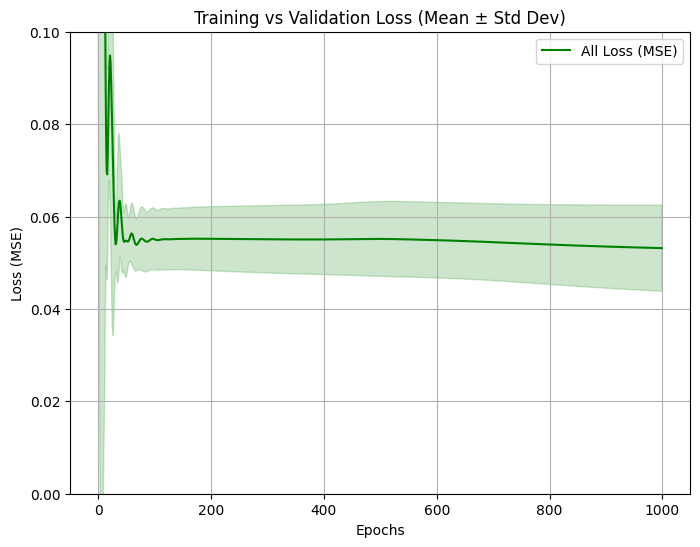

Final MSE: 0.05316141385257829
Final val error: 0.04041966922725535


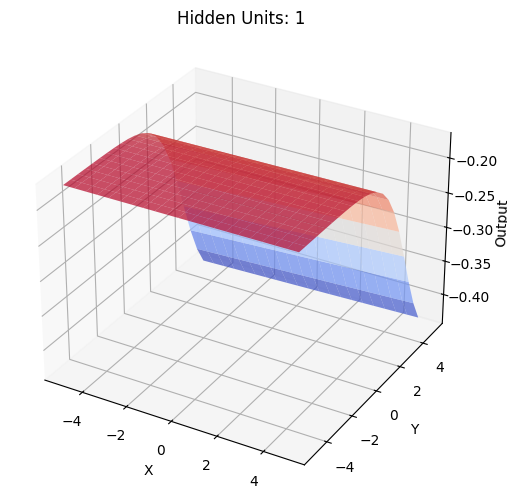


Training with 2 hidden units...


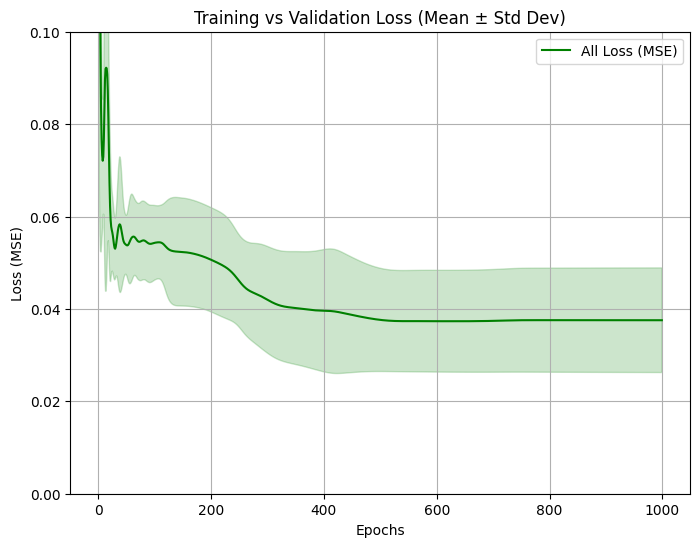

Final MSE: 0.0375530436639145
Final val error: 0.03385844978372847


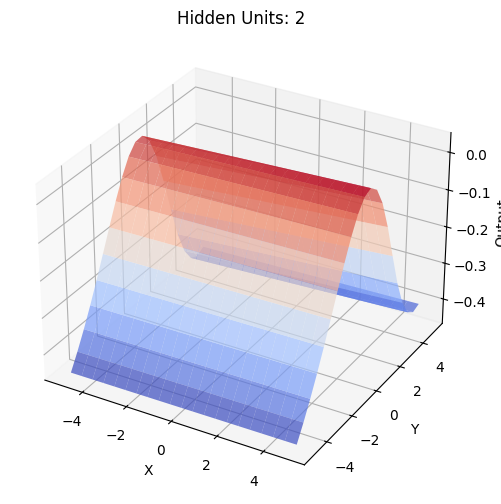


Training with 3 hidden units...


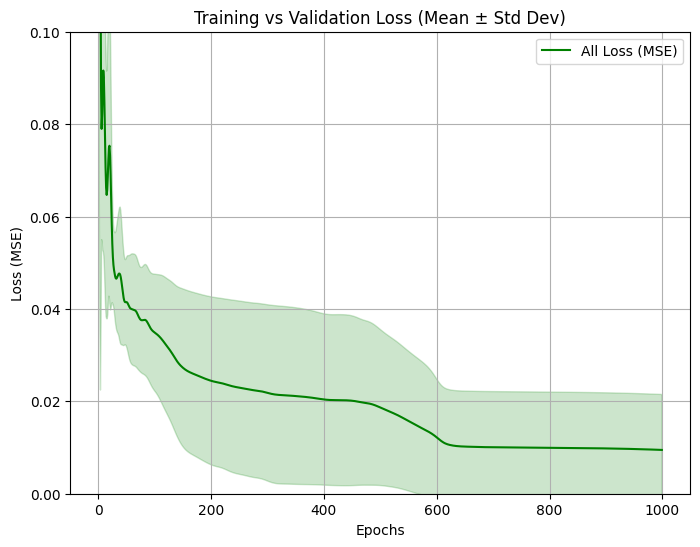

Final MSE: 0.009480104552916093
Final val error: 0.009813071596123803


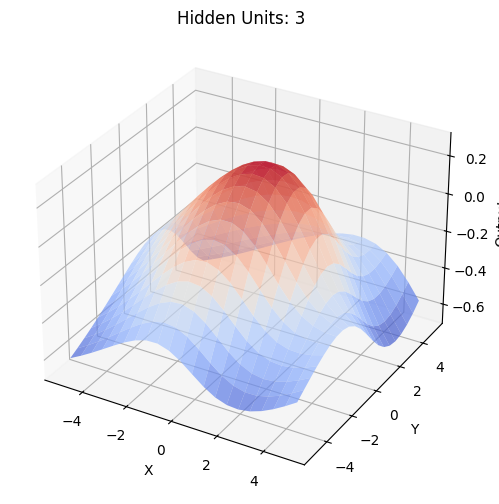


Training with 5 hidden units...


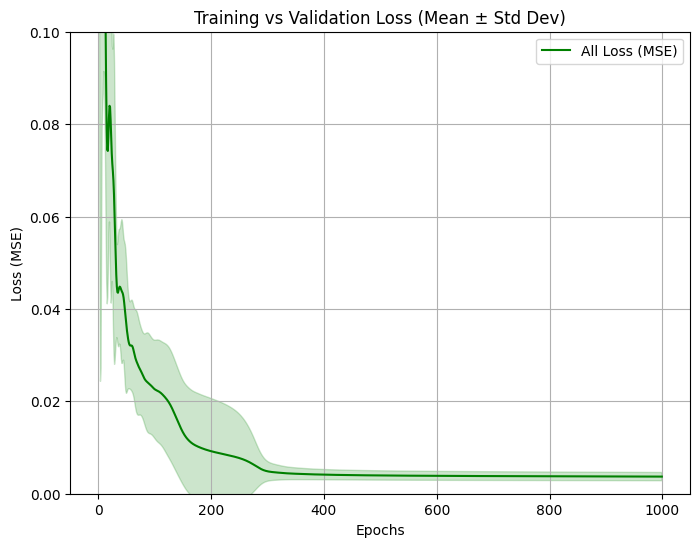

Final MSE: 0.003706823065292679
Final val error: 0.003823273627314591


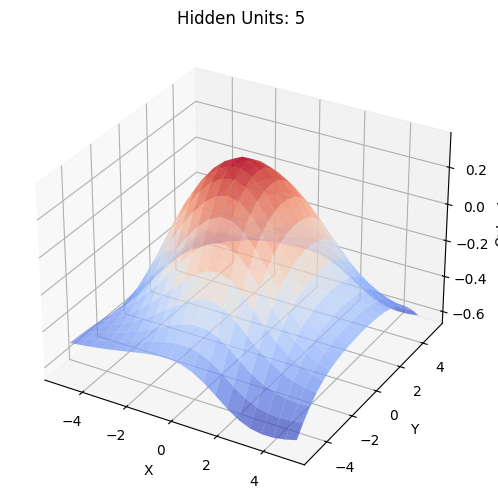


Training with 10 hidden units...


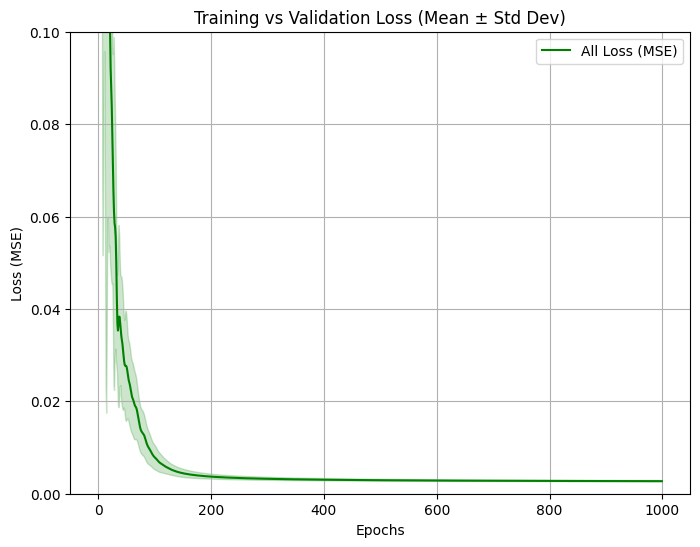

Final MSE: 0.002716702769015483
Final val error: 0.0029189957928155022


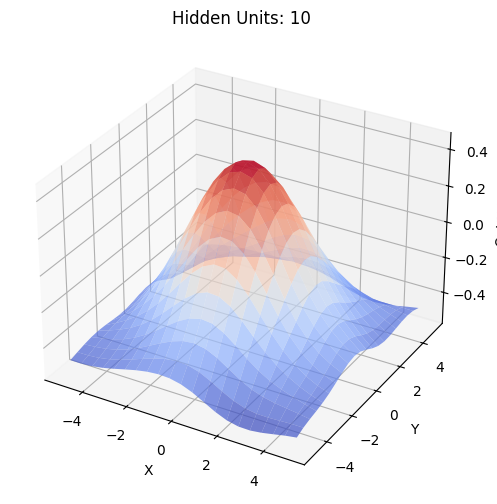


Training with 20 hidden units...


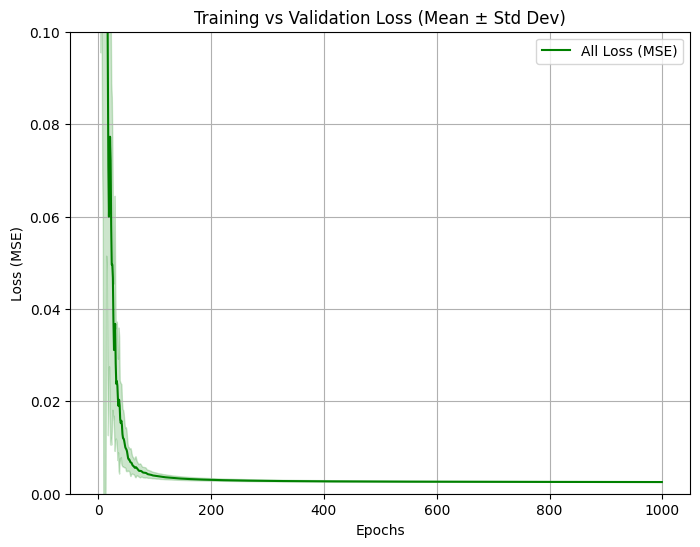

Final MSE: 0.002528085419195122
Final val error: 0.002704844530225174


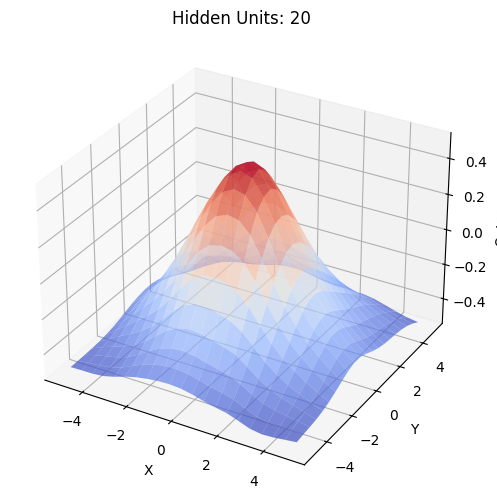


Training with 25 hidden units...


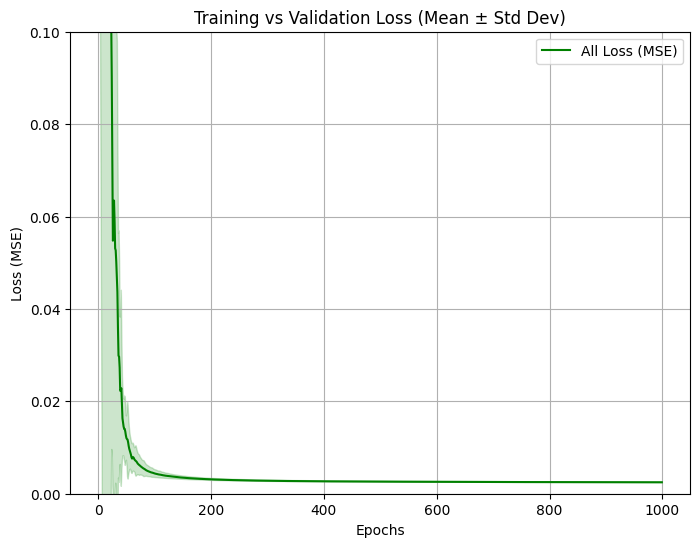

Final MSE: 0.002475241120519643
Final val error: 0.0026682624107167425


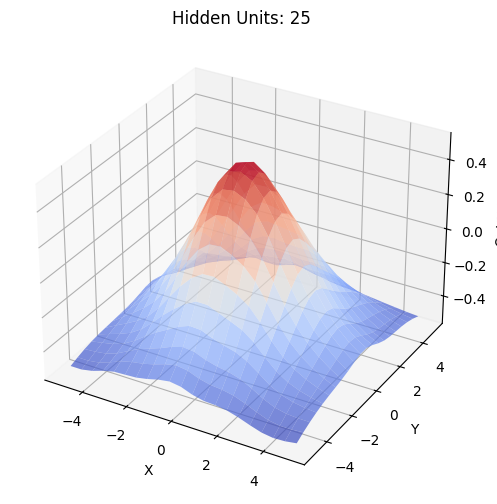


Best model found: 25 hidden units with MSE: 0.00267


In [ ]:
# 1. Find the best model
lr = 0.01
epochs = 1000
alpha = 0.9
seed = 42
np.random.seed(seed)
best_model, best_hidden_size = find_best_hidden_units([1, 2, 3, 5, 10, 20, 25])

Using best size: 25

Training with 80% of data (352 samples)...


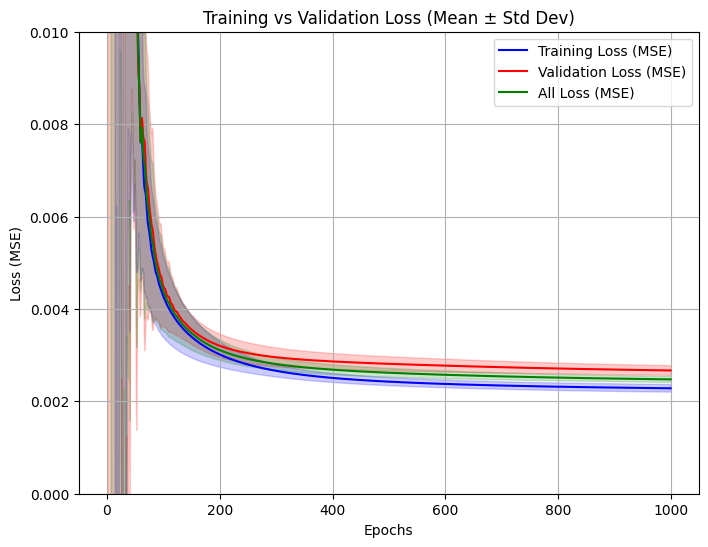

Final MSE: 0.002475241120519643


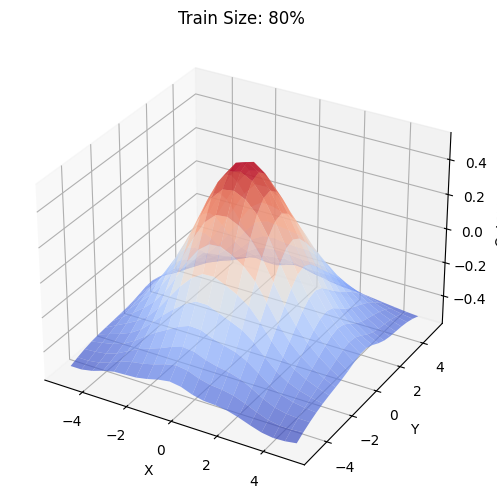


Training with 60% of data (264 samples)...


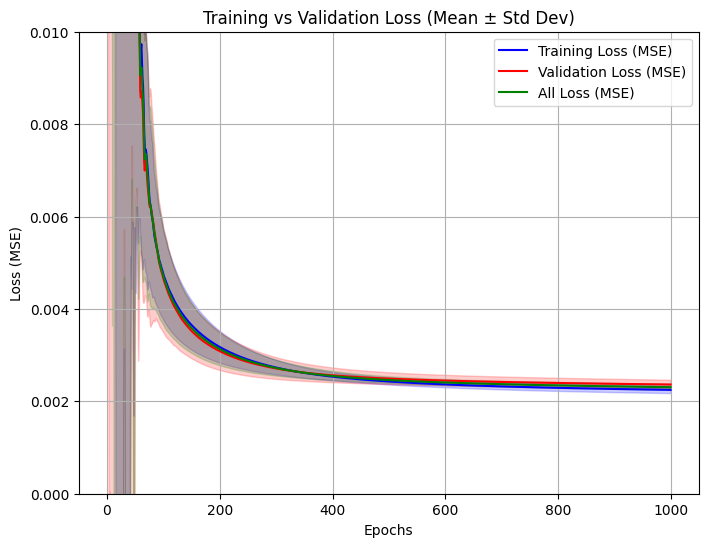

Final MSE: 0.0023060072886941035


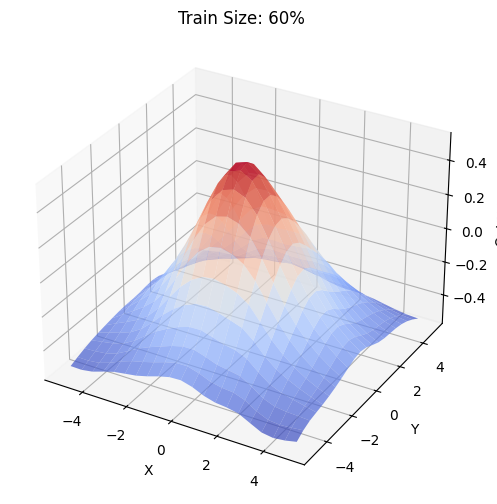


Training with 40% of data (176 samples)...


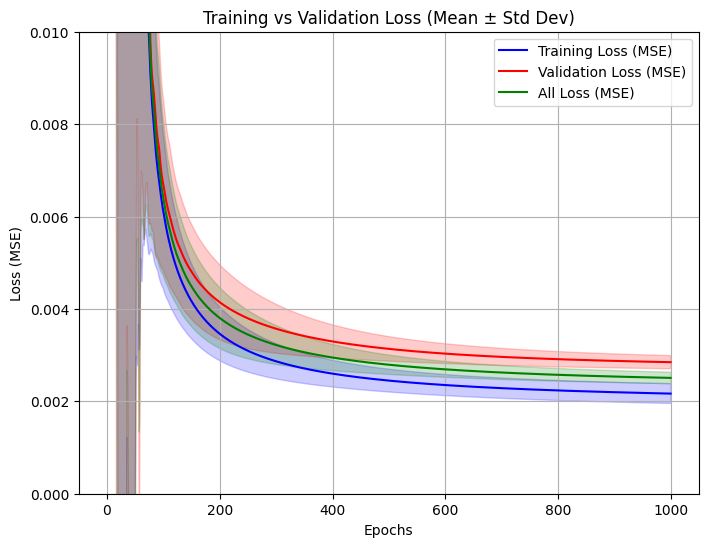

Final MSE: 0.002507152742701123


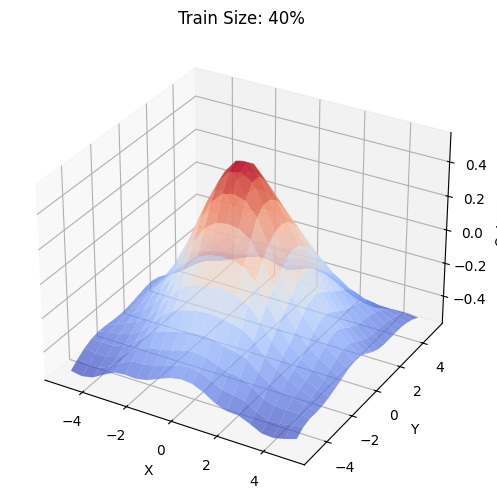


Training with 20% of data (88 samples)...


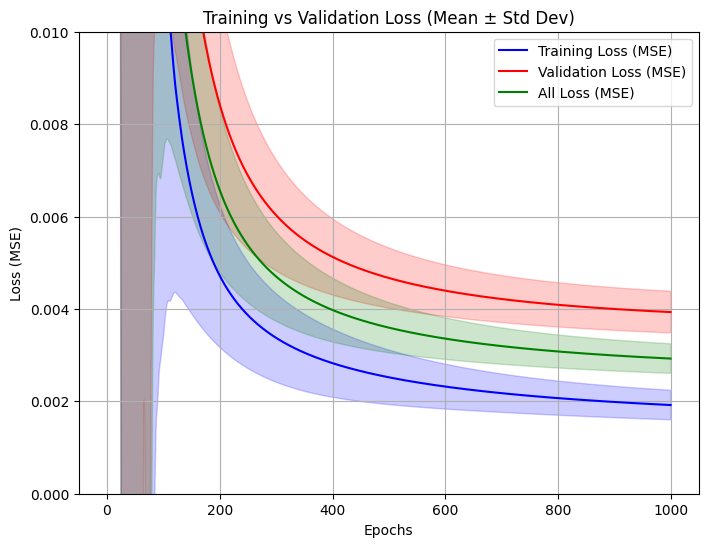

Final MSE: 0.002925467455985112


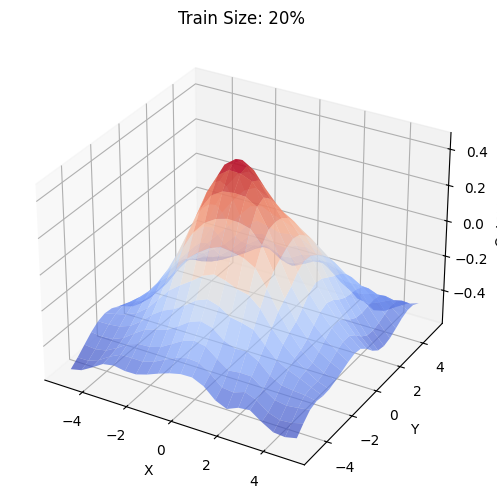

In [ ]:
# Experiment 2: Varying training data size
def experiment_training_data_sizes(best_hidden_size, X, T, x, y, train_sizes=[0.8, 0.6, 0.4, 0.2], epochs=200):
    for train_size in train_sizes:
        if train_size == 0.8:
            scenario = "80%"
        elif train_size == 0.6:
            scenario = "60%"
        elif train_size == 0.4:
            scenario = "40%"
        elif train_size == 0.2:
            scenario = "20%"
        nsamp = int(train_size * X.shape[1])
        print(f"\nTraining with {train_size * 100:.0f}% of data ({nsamp} samples)...")
        MSE_train, acc_train, MSE_val, acc_val, model = training_multiple_runs_split_with_approx(
            TwoLayerPerceptron, input_size, output_size, best_hidden_size, lr, alpha,
            X, T, epochs, n_runs, scenario)

        # Compute and plot the average loss across runs
        error_ceiling = 0.01
        plot_average_metrics_split_and_all(MSE_train, acc_train, MSE_val, acc_val, error_ceiling)


        visualize_results(model, X, x, y, title=f"Train Size: {train_size*100:.0f}%")

lr = 0.01
epochs = 1000
alpha = 0.9
n_runs = 10
seed = 42
np.random.seed(seed)
X, T, x, y, zz = generate_gaussian_data(grid_size=21, noise=0.05)
# 2. Experiment with training data sizes
print("Using best size: " + str(best_hidden_size))
experiment_training_data_sizes(best_hidden_size, X, T, x, y, train_sizes=[0.8, 0.6, 0.4, 0.2], epochs=epochs)

25

Experimenting with higher learning rate and lower momentum...


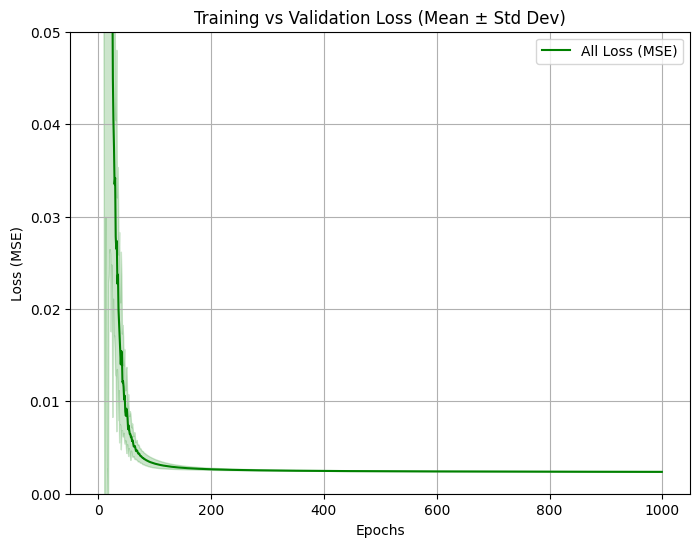

Final MSE: 0.002364558118719604


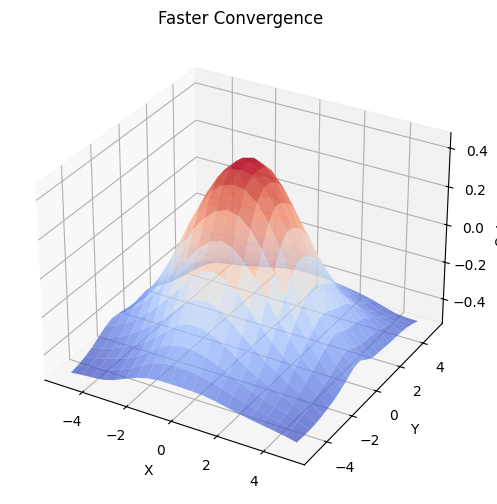

In [ ]:
# Experiment 3: Speeding up convergence
def experiment_speedup_convergence(best_hidden_size, X, T, epochs, lr=0.1, alpha=0.3):
    print("\nExperimenting with higher learning rate and lower momentum...")
    MSE_train, acc_train, MSE_val, acc_val, model = training_multiple_runs_split_with_approx(
            TwoLayerPerceptron, input_size, output_size, best_hidden_size, lr, alpha,
            X, T, epochs, n_runs, "100%", plot_val=False, lr_adapt=False)

    # Compute and plot the average loss across runs
    error_ceiling = 0.05
    plot_average_metrics_split_and_all(MSE_train, acc_train, MSE_val, acc_val, error_ceiling, plot_val=False)

    visualize_results(model, X, x, y, title=f"Faster Convergence")

print(best_hidden_size)
seed = 42
X, T, x, y, zz = generate_gaussian_data(grid_size=21, noise=0.05)
#model = TwoLayerPerceptron(input_size=input_size, hidden_size=best_hidden_size, output_size=1, lr=0.01, alpha=0.3)
# 3. Experiment with speeding up convergence
experiment_speedup_convergence(best_hidden_size, X, T, epochs, lr=0.03, alpha=0.9)